# Assignment 7: Semantic Segmentation
Heute werden wir einfache Netzwerkarchitekturen für "Semantic Segmentation" testen. Ziel ist es dieses Paper in den Grundzügen zu implementieren: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf. Bitte lesen!

## Daten

Es gibt einige gute Datensätze, die ihr (bei gegebener Hardware) herunterladen und benutzen könnt. Für diejenigen, die auf CPUs rechnen gilt immer der Tip: Bilder downsamplen!

Sucht Euch einen Satensatz aus: 

KITTI: http://www.cvlibs.net/download.php?file=data_semantics.zip (~300 MB, 200 Bilder)

DUS: http://www.6d-vision.com/scene-labeling (~3 GB, 500 Bilder)

MIT. http://sceneparsing.csail.mit.edu/ (~1 GB, links siehe auf Seite)

## Exc. 7.1 Fully convolutional network, no downsampling
Implementiere die in der Vorlesung besprochene Netzwerkarchitektur von aufeinanderfolgenden CONV-Schichten (stride=1, mit zero-padding), um eine Ausgabeschicht zu bekommen, die die Eingabegröße aufweist. Tip: die letzte CONV-Schicht sollte eine Tiefe haben, die zur Zahl der Klassen korrespondiert. Benutze den L2-Loss zum Labelbild (Achtung: ihr müsst dafür entweder das Labelbild oder den Ausgabetensor umformulieren).

Trainiere das Netzwerk auf den von Dir gewählten Datensatz und zeige den Verlauf des Losses, und einige zufällig gewählte Beispielbilder mit ihren vorhergesagten Segmentierungen an. (**RESULT**)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import tensorflow as tf
import sys

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import binarize

from keras.backend.tensorflow_backend import set_session, get_session
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.backend import argmax, cast
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import optimizers

from skimage import color, io, transform

import PIL

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


def loadImageBatch(path, offset, number, targetShape=None):
    imagePaths = []
    for file in os.listdir(path):
        ext = os.path.splitext(file)[1]
        if ext.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        imagePaths.append(os.path.join(path, file))
    imagePaths.sort()

    if offset >= len(imagePaths):
        return []
    if offset + number > len(imagePaths):
        number = len(imagePaths) - offset

    images = []  # io.imread_collection(imagePaths[offset:offset+number])
    for imgPath in imagePaths[offset:(offset + number)]:
        # print(imgPath)
        images.append(io.imread(imgPath))

    if targetShape != None:
        for i in range(0, len(images)):
            images[i] = rescale(images[i], targetShape)
    return images


def rescale(img, shape):
    img = transform.resize(img, shape)
    return img


def preprocessBatch(images):
    for i in range(0, len(images)):
        images[i] = preprocess(images[i])
    return images


def preprocess(img):    
    height, width, dim = img.shape
    result = np.zeros((height, width, 150), np.float32)
    
    for y in range(0, height):
        for x in range(0, width):
            dim = int(img[y, x, 0] * 255)
            result[y, x, dim] = 1.0
    
    return result



D:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:

image_generator = ImageDataGenerator()
label_generator = ImageDataGenerator(preprocessing_function=preprocess)

# Beispiel für den KITTI-Datensatz. Ich habe die 200 training samples in 180 train- und 20 testbilder
# geteilt (macht 180 samples inkl. labels)
# um uns das Leben leichter zu machen, Bilder heruntersamplen

img_size = (60, 80)

train_image_path = os.path.join("semantic_segmentation_2", "images", "training", "training")
train_label_path = os.path.join("semantic_segmentation_2", "annotations", "training", "training")


In [28]:
input_shape = (img_size[0], img_size[1], 3)
print(input_shape)
lr = 0.0005

model = Sequential()
model.add(Conv2D(3, img_size, activation="relu", padding="same", input_shape=input_shape))
model.add(Conv2D(3, (31,31), activation="relu", padding="same"))
model.add(Conv2D(3, (15, 15), activation="relu", padding="same"))
model.add(Conv2D(3, (7,7), activation="relu", padding="same"))
model.add(Conv2D(3, (5,5), activation="relu", padding="same"))
model.add(Conv2D(3, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(3, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(3, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(150, (1, 1), activation="relu", padding="same"))

model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=lr),
              metrics=['accuracy'])

model.summary()

(60, 80, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 60, 80, 3)         43203     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 80, 3)         8652      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 80, 3)         2028      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 80, 3)         444       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 60, 80, 3)         228       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 80, 3)         84        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 80, 3)         84       

In [29]:
def gen(train_image_path, train_label_path, img_size):
    offset = 0
    while True:
        train_batch = loadImageBatch(train_image_path, offset, 1, img_size)
        label_batch = preprocessBatch(loadImageBatch(train_label_path, offset, 1, img_size))
        offset += 1
        if (len(train_batch) == 0):
            raise StopIteration
        
        train_batch = np.array(train_batch)
        label_batch = np.array(label_batch)
        
        if len(train_batch.shape) != 4:
            print("Detected wrong shape!")
            continue
        
        yield(train_batch, label_batch)


train2_generator = gen(train_image_path, train_label_path, img_size)
# about 20.210 images


In [32]:
a = model.fit_generator(train2_generator, steps_per_epoch = 100, epochs = 20)

Epoch 1/20


  1/100 [..............................] - ETA: 33s - loss: 0.0046 - acc: 0.5560

  2/100 [..............................] - ETA: 31s - loss: 0.0051 - acc: 0.4726

  3/100 [..............................] - ETA: 33s - loss: 0.0048 - acc: 0.5256

  4/100 [>.............................] - ETA: 31s - loss: 0.0053 - acc: 0.4541

  5/100 [>.............................] - ETA: 30s - loss: 0.0049 - acc: 0.5199

  6/100 [>.............................] - ETA: 29s - loss: 0.0046 - acc: 0.5598

  7/100 [=>............................] - ETA: 29s - loss: 0.0046 - acc: 0.5576

  8/100 [=>............................] - ETA: 28s - loss: 0.0046 - acc: 0.5642

  9/100 [=>............................] - ETA: 28s - loss: 0.0046 - acc: 0.5581

 10/100 [==>...........................] - ETA: 28s - loss: 0.0046 - acc: 0.5650

 11/100 [==>...........................] - ETA: 28s - loss: 0.0046 - acc: 0.5527

 12/100 [==>...........................] - ETA: 27s - loss: 0.0046 - acc: 0.5539

 13/100 [==>...........................] - ETA: 27s - loss: 0.0047 - acc: 0.5498

 14/100 [===>..........................] - ETA: 26s - loss: 0.0047 - acc: 0.5494

 15/100 [===>..........................] - ETA: 26s - loss: 0.0047 - acc: 0.5466

 16/100 [===>..........................] - ETA: 25s - loss: 0.0047 - acc: 0.5400

 17/100 [====>.........................] - ETA: 25s - loss: 0.0047 - acc: 0.5434

 18/100 [====>.........................] - ETA: 25s - loss: 0.0047 - acc: 0.5394

 19/100 [====>.........................] - ETA: 24s - loss: 0.0048 - acc: 0.5251

 20/100 [=====>........................] - ETA: 24s - loss: 0.0048 - acc: 0.5276

 21/100 [=====>........................] - ETA: 24s - loss: 0.0048 - acc: 0.5276

 22/100 [=====>........................] - ETA: 23s - loss: 0.0048 - acc: 0.5297

 23/100 [=====>........................] - ETA: 23s - loss: 0.0048 - acc: 0.5286

 24/100 [======>.......................] - ETA: 23s - loss: 0.0048 - acc: 0.5266

 25/100 [======>.......................] - ETA: 22s - loss: 0.0048 - acc: 0.5276

 26/100 [======>.......................] - ETA: 22s - loss: 0.0049 - acc: 0.5232

 27/100 [=======>......................] - ETA: 22s - loss: 0.0049 - acc: 0.5225

 28/100 [=======>......................] - ETA: 21s - loss: 0.0049 - acc: 0.5126

 29/100 [=======>......................] - ETA: 21s - loss: 0.0049 - acc: 0.5101

 30/100 [========>.....................] - ETA: 21s - loss: 0.0050 - acc: 0.5078

 31/100 [========>.....................] - ETA: 20s - loss: 0.0050 - acc: 0.5090

 32/100 [========>.....................] - ETA: 20s - loss: 0.0049 - acc: 0.5120

 33/100 [========>.....................] - ETA: 20s - loss: 0.0049 - acc: 0.5132

 34/100 [=========>....................] - ETA: 19s - loss: 0.0049 - acc: 0.5180

 35/100 [=========>....................] - ETA: 19s - loss: 0.0049 - acc: 0.5208

 36/100 [=========>....................] - ETA: 19s - loss: 0.0048 - acc: 0.5258

 37/100 [==========>...................] - ETA: 18s - loss: 0.0049 - acc: 0.5230

 38/100 [==========>...................] - ETA: 18s - loss: 0.0048 - acc: 0.5264

 39/100 [==========>...................] - ETA: 18s - loss: 0.0048 - acc: 0.5268

 40/100 [===========>..................] - ETA: 18s - loss: 0.0048 - acc: 0.5301

 41/100 [===========>..................] - ETA: 17s - loss: 0.0048 - acc: 0.5303

 42/100 [===========>..................] - ETA: 17s - loss: 0.0048 - acc: 0.5299

 43/100 [===========>..................] - ETA: 17s - loss: 0.0048 - acc: 0.5301

 44/100 [============>.................] - ETA: 16s - loss: 0.0048 - acc: 0.5304

 45/100 [============>.................] - ETA: 16s - loss: 0.0048 - acc: 0.5334

 46/100 [============>.................] - ETA: 16s - loss: 0.0048 - acc: 0.5367

 47/100 [=============>................] - ETA: 15s - loss: 0.0048 - acc: 0.5349

 48/100 [=============>................] - ETA: 15s - loss: 0.0048 - acc: 0.5359

 49/100 [=============>................] - ETA: 15s - loss: 0.0048 - acc: 0.5358

 50/100 [==============>...............] - ETA: 15s - loss: 0.0048 - acc: 0.5330

 51/100 [==============>...............] - ETA: 14s - loss: 0.0048 - acc: 0.5298

 52/100 [==============>...............] - ETA: 14s - loss: 0.0048 - acc: 0.5309

 53/100 [==============>...............] - ETA: 14s - loss: 0.0048 - acc: 0.5313

 54/100 [===============>..............] - ETA: 13s - loss: 0.0048 - acc: 0.5300

 55/100 [===============>..............] - ETA: 13s - loss: 0.0048 - acc: 0.5288

 56/100 [===============>..............] - ETA: 13s - loss: 0.0048 - acc: 0.5259

 57/100 [================>.............] - ETA: 12s - loss: 0.0048 - acc: 0.5244

 58/100 [================>.............] - ETA: 12s - loss: 0.0048 - acc: 0.5240

 59/100 [================>.............] - ETA: 12s - loss: 0.0048 - acc: 0.5243

 60/100 [=================>............] - ETA: 11s - loss: 0.0049 - acc: 0.5238

 61/100 [=================>............] - ETA: 11s - loss: 0.0049 - acc: 0.5235

 62/100 [=================>............] - ETA: 11s - loss: 0.0049 - acc: 0.5223

 63/100 [=================>............] - ETA: 11s - loss: 0.0049 - acc: 0.5237

 64/100 [==================>...........] - ETA: 10s - loss: 0.0048 - acc: 0.5265

 65/100 [==================>...........] - ETA: 10s - loss: 0.0048 - acc: 0.5288

 66/100 [==================>...........] - ETA: 10s - loss: 0.0048 - acc: 0.5279

 67/100 [===================>..........] - ETA: 9s - loss: 0.0048 - acc: 0.5273 

 68/100 [===================>..........] - ETA: 9s - loss: 0.0048 - acc: 0.5251

 69/100 [===================>..........] - ETA: 9s - loss: 0.0048 - acc: 0.5242

 70/100 [====================>.........] - ETA: 8s - loss: 0.0048 - acc: 0.5246

 71/100 [====================>.........] - ETA: 8s - loss: 0.0048 - acc: 0.5240

 72/100 [====================>.........] - ETA: 8s - loss: 0.0049 - acc: 0.5236

 73/100 [====================>.........] - ETA: 8s - loss: 0.0048 - acc: 0.5243

 74/100 [=====================>........] - ETA: 7s - loss: 0.0048 - acc: 0.5249

 75/100 [=====================>........] - ETA: 7s - loss: 0.0048 - acc: 0.5242

 76/100 [=====================>........] - ETA: 7s - loss: 0.0048 - acc: 0.5268

 77/100 [======================>.......] - ETA: 6s - loss: 0.0048 - acc: 0.5267

 78/100 [======================>.......] - ETA: 6s - loss: 0.0048 - acc: 0.5286

 79/100 [======================>.......] - ETA: 6s - loss: 0.0048 - acc: 0.5275

 80/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5270

 81/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5289

 82/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5277

 83/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5294

 84/100 [========================>.....] - ETA: 4s - loss: 0.0048 - acc: 0.5293

 85/100 [========================>.....] - ETA: 4s - loss: 0.0048 - acc: 0.5312

 86/100 [========================>.....] - ETA: 4s - loss: 0.0048 - acc: 0.5312

 87/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5325

 88/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5319

 89/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5334

 90/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5314

 91/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5320

 92/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5311

 93/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5313

 94/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5307

 95/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5306

 96/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5315

 97/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5318

 98/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5310

 99/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5316

100/100 [==============================] - 30s 299ms/step - loss: 0.0048 - acc: 0.5298


Epoch 2/20


  1/100 [..............................] - ETA: 27s - loss: 0.0050 - acc: 0.5010

  2/100 [..............................] - ETA: 28s - loss: 0.0053 - acc: 0.4520

  3/100 [..............................] - ETA: 28s - loss: 0.0050 - acc: 0.4949

  4/100 [>.............................] - ETA: 28s - loss: 0.0048 - acc: 0.5318

  5/100 [>.............................] - ETA: 27s - loss: 0.0046 - acc: 0.5606

  6/100 [>.............................] - ETA: 27s - loss: 0.0047 - acc: 0.5413

  7/100 [=>............................] - ETA: 27s - loss: 0.0047 - acc: 0.5402

  8/100 [=>............................] - ETA: 27s - loss: 0.0047 - acc: 0.5501

  9/100 [=>............................] - ETA: 26s - loss: 0.0047 - acc: 0.5368

 10/100 [==>...........................] - ETA: 26s - loss: 0.0048 - acc: 0.5358

 11/100 [==>...........................] - ETA: 26s - loss: 0.0047 - acc: 0.5468

 12/100 [==>...........................] - ETA: 25s - loss: 0.0046 - acc: 0.5513

 13/100 [==>...........................] - ETA: 25s - loss: 0.0048 - acc: 0.5291

 14/100 [===>..........................] - ETA: 25s - loss: 0.0049 - acc: 0.5149

 15/100 [===>..........................] - ETA: 24s - loss: 0.0049 - acc: 0.5154

 16/100 [===>..........................] - ETA: 24s - loss: 0.0048 - acc: 0.5214

 17/100 [====>.........................] - ETA: 24s - loss: 0.0048 - acc: 0.5302

 18/100 [====>.........................] - ETA: 24s - loss: 0.0048 - acc: 0.5329

 19/100 [====>.........................] - ETA: 23s - loss: 0.0048 - acc: 0.5345

 20/100 [=====>........................] - ETA: 23s - loss: 0.0048 - acc: 0.5346

 21/100 [=====>........................] - ETA: 23s - loss: 0.0047 - acc: 0.5420

 22/100 [=====>........................] - ETA: 22s - loss: 0.0047 - acc: 0.5376

 23/100 [=====>........................] - ETA: 22s - loss: 0.0047 - acc: 0.5462

 24/100 [======>.......................] - ETA: 22s - loss: 0.0048 - acc: 0.5354

 25/100 [======>.......................] - ETA: 22s - loss: 0.0048 - acc: 0.5357

 26/100 [======>.......................] - ETA: 21s - loss: 0.0048 - acc: 0.5279

 27/100 [=======>......................] - ETA: 21s - loss: 0.0048 - acc: 0.5302

 28/100 [=======>......................] - ETA: 21s - loss: 0.0048 - acc: 0.5281

 29/100 [=======>......................] - ETA: 20s - loss: 0.0048 - acc: 0.5289

 30/100 [========>.....................] - ETA: 20s - loss: 0.0048 - acc: 0.5291

 31/100 [========>.....................] - ETA: 20s - loss: 0.0048 - acc: 0.5303

 32/100 [========>.....................] - ETA: 20s - loss: 0.0048 - acc: 0.5312

 33/100 [========>.....................] - ETA: 19s - loss: 0.0047 - acc: 0.5347

 34/100 [=========>....................] - ETA: 19s - loss: 0.0047 - acc: 0.5372

 35/100 [=========>....................] - ETA: 19s - loss: 0.0047 - acc: 0.5346

 36/100 [=========>....................] - ETA: 18s - loss: 0.0047 - acc: 0.5366

 37/100 [==========>...................] - ETA: 18s - loss: 0.0047 - acc: 0.5354

 38/100 [==========>...................] - ETA: 18s - loss: 0.0047 - acc: 0.5354

 39/100 [==========>...................] - ETA: 18s - loss: 0.0048 - acc: 0.5327

 40/100 [===========>..................] - ETA: 17s - loss: 0.0048 - acc: 0.5324

 41/100 [===========>..................] - ETA: 17s - loss: 0.0047 - acc: 0.5371

 42/100 [===========>..................] - ETA: 17s - loss: 0.0047 - acc: 0.5380

 43/100 [===========>..................] - ETA: 16s - loss: 0.0047 - acc: 0.5393

 44/100 [============>.................] - ETA: 16s - loss: 0.0047 - acc: 0.5352

 45/100 [============>.................] - ETA: 16s - loss: 0.0048 - acc: 0.5312

 46/100 [============>.................] - ETA: 15s - loss: 0.0047 - acc: 0.5365

 47/100 [=============>................] - ETA: 15s - loss: 0.0047 - acc: 0.5464

 48/100 [=============>................] - ETA: 15s - loss: 0.0047 - acc: 0.5460

 49/100 [=============>................] - ETA: 15s - loss: 0.0046 - acc: 0.5552

 50/100 [==============>...............] - ETA: 14s - loss: 0.0045 - acc: 0.5641

 51/100 [==============>...............] - ETA: 14s - loss: 0.0046 - acc: 0.5553

 52/100 [==============>...............] - ETA: 14s - loss: 0.0046 - acc: 0.5501

 53/100 [==============>...............] - ETA: 13s - loss: 0.0046 - acc: 0.5585

 54/100 [===============>..............] - ETA: 13s - loss: 0.0046 - acc: 0.5588

 55/100 [===============>..............] - ETA: 13s - loss: 0.0045 - acc: 0.5668

 56/100 [===============>..............] - ETA: 12s - loss: 0.0045 - acc: 0.5733

 57/100 [================>.............] - ETA: 12s - loss: 0.0044 - acc: 0.5805

 58/100 [================>.............] - ETA: 12s - loss: 0.0044 - acc: 0.5875

 59/100 [================>.............] - ETA: 11s - loss: 0.0043 - acc: 0.5904

 60/100 [=================>............] - ETA: 11s - loss: 0.0043 - acc: 0.5938

 61/100 [=================>............] - ETA: 11s - loss: 0.0043 - acc: 0.5996

 62/100 [=================>............] - ETA: 11s - loss: 0.0043 - acc: 0.5985

 63/100 [=================>............] - ETA: 10s - loss: 0.0043 - acc: 0.6010

 64/100 [==================>...........] - ETA: 10s - loss: 0.0042 - acc: 0.6062

 65/100 [==================>...........] - ETA: 10s - loss: 0.0042 - acc: 0.6103

 66/100 [==================>...........] - ETA: 9s - loss: 0.0042 - acc: 0.6044 

 67/100 [===================>..........] - ETA: 9s - loss: 0.0042 - acc: 0.6065

 68/100 [===================>..........] - ETA: 9s - loss: 0.0042 - acc: 0.6079

 69/100 [===================>..........] - ETA: 8s - loss: 0.0042 - acc: 0.6135

 70/100 [====================>.........] - ETA: 8s - loss: 0.0041 - acc: 0.6190

 71/100 [====================>.........] - ETA: 8s - loss: 0.0041 - acc: 0.6203

 72/100 [====================>.........] - ETA: 8s - loss: 0.0041 - acc: 0.6214

 73/100 [====================>.........] - ETA: 7s - loss: 0.0041 - acc: 0.6258

 74/100 [=====================>........] - ETA: 7s - loss: 0.0041 - acc: 0.6250

 75/100 [=====================>........] - ETA: 7s - loss: 0.0040 - acc: 0.6279

 76/100 [=====================>........] - ETA: 6s - loss: 0.0041 - acc: 0.6215

 77/100 [======================>.......] - ETA: 6s - loss: 0.0041 - acc: 0.6209

 78/100 [======================>.......] - ETA: 6s - loss: 0.0041 - acc: 0.6245

 79/100 [======================>.......] - ETA: 6s - loss: 0.0040 - acc: 0.6293

 80/100 [=======================>......] - ETA: 5s - loss: 0.0040 - acc: 0.6339

 81/100 [=======================>......] - ETA: 5s - loss: 0.0040 - acc: 0.6383

 82/100 [=======================>......] - ETA: 5s - loss: 0.0039 - acc: 0.6427

 83/100 [=======================>......] - ETA: 4s - loss: 0.0039 - acc: 0.6470

 84/100 [========================>.....] - ETA: 4s - loss: 0.0039 - acc: 0.6418

 85/100 [========================>.....] - ETA: 4s - loss: 0.0039 - acc: 0.6460

 86/100 [========================>.....] - ETA: 3s - loss: 0.0038 - acc: 0.6501

 87/100 [=========================>....] - ETA: 3s - loss: 0.0038 - acc: 0.6540

 88/100 [=========================>....] - ETA: 3s - loss: 0.0038 - acc: 0.6577

 89/100 [=========================>....] - ETA: 3s - loss: 0.0037 - acc: 0.6616

 90/100 [==========================>...] - ETA: 2s - loss: 0.0037 - acc: 0.6645

 91/100 [==========================>...] - ETA: 2s - loss: 0.0037 - acc: 0.6682

 92/100 [==========================>...] - ETA: 2s - loss: 0.0036 - acc: 0.6717

 93/100 [==========================>...] - ETA: 1s - loss: 0.0036 - acc: 0.6753

 94/100 [===========================>..] - ETA: 1s - loss: 0.0036 - acc: 0.6778

 95/100 [===========================>..] - ETA: 1s - loss: 0.0035 - acc: 0.6812

 96/100 [===========================>..] - ETA: 1s - loss: 0.0035 - acc: 0.6845

 97/100 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.6877

 98/100 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.6909

 99/100 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.6940

100/100 [==============================] - 28s 283ms/step - loss: 0.0034 - acc: 0.6971


Epoch 3/20


  1/100 [..............................] - ETA: 25s - loss: 0.0043 - acc: 0.6585

  2/100 [..............................] - ETA: 27s - loss: 0.0022 - acc: 0.8293

  3/100 [..............................] - ETA: 26s - loss: 0.0015 - acc: 0.8862

  4/100 [>.............................] - ETA: 25s - loss: 0.0011 - acc: 0.9146

  5/100 [>.............................] - ETA: 25s - loss: 9.2450e-04 - acc: 0.9314

  6/100 [>.............................] - ETA: 24s - loss: 7.8097e-04 - acc: 0.9428

  7/100 [=>............................] - ETA: 24s - loss: 6.9648e-04 - acc: 0.9496

  8/100 [=>............................] - ETA: 24s - loss: 6.2221e-04 - acc: 0.9553

  9/100 [=>............................] - ETA: 24s - loss: 5.9190e-04 - acc: 0.9576

 10/100 [==>...........................] - ETA: 24s - loss: 5.5251e-04 - acc: 0.9606

 11/100 [==>...........................] - ETA: 23s - loss: 5.0595e-04 - acc: 0.9642

 12/100 [==>...........................] - ETA: 23s - loss: 5.7046e-04 - acc: 0.9591

 13/100 [==>...........................] - ETA: 23s - loss: 5.3026e-04 - acc: 0.9622

 14/100 [===>..........................] - ETA: 23s - loss: 5.0904e-04 - acc: 0.9638

 15/100 [===>..........................] - ETA: 22s - loss: 5.7891e-04 - acc: 0.9586

 16/100 [===>..........................] - ETA: 22s - loss: 5.7188e-04 - acc: 0.9592

 17/100 [====>.........................] - ETA: 22s - loss: 5.7408e-04 - acc: 0.9590

 18/100 [====>.........................] - ETA: 22s - loss: 5.4421e-04 - acc: 0.9613

 19/100 [====>.........................] - ETA: 22s - loss: 5.3032e-04 - acc: 0.9624

 20/100 [=====>........................] - ETA: 21s - loss: 5.3374e-04 - acc: 0.9621

 21/100 [=====>........................] - ETA: 21s - loss: 5.0998e-04 - acc: 0.9639

 22/100 [=====>........................] - ETA: 21s - loss: 4.9835e-04 - acc: 0.9648

 23/100 [=====>........................] - ETA: 21s - loss: 4.9930e-04 - acc: 0.9647

 24/100 [======>.......................] - ETA: 20s - loss: 5.0484e-04 - acc: 0.9643

 25/100 [======>.......................] - ETA: 20s - loss: 5.4357e-04 - acc: 0.9614

 26/100 [======>.......................] - ETA: 20s - loss: 5.5746e-04 - acc: 0.9603

 27/100 [=======>......................] - ETA: 20s - loss: 5.5736e-04 - acc: 0.9603

 28/100 [=======>......................] - ETA: 19s - loss: 5.9986e-04 - acc: 0.9571

 29/100 [=======>......................] - ETA: 19s - loss: 6.0980e-04 - acc: 0.9563

 30/100 [========>.....................] - ETA: 19s - loss: 6.0075e-04 - acc: 0.9570

 31/100 [========>.....................] - ETA: 19s - loss: 5.9806e-04 - acc: 0.9572

 32/100 [========>.....................] - ETA: 18s - loss: 5.8301e-04 - acc: 0.9583

 33/100 [========>.....................] - ETA: 18s - loss: 6.7100e-04 - acc: 0.9514

 34/100 [=========>....................] - ETA: 18s - loss: 6.5936e-04 - acc: 0.9523

 35/100 [=========>....................] - ETA: 17s - loss: 6.5339e-04 - acc: 0.9528

 36/100 [=========>....................] - ETA: 17s - loss: 6.5703e-04 - acc: 0.9525

 37/100 [==========>...................] - ETA: 17s - loss: 6.4539e-04 - acc: 0.9534

 38/100 [==========>...................] - ETA: 17s - loss: 6.3398e-04 - acc: 0.9543

 39/100 [==========>...................] - ETA: 16s - loss: 6.3627e-04 - acc: 0.9541

 40/100 [===========>..................] - ETA: 16s - loss: 6.5515e-04 - acc: 0.9526

 41/100 [===========>..................] - ETA: 16s - loss: 6.7921e-04 - acc: 0.9506

 42/100 [===========>..................] - ETA: 16s - loss: 7.2722e-04 - acc: 0.9468

 43/100 [===========>..................] - ETA: 15s - loss: 7.6533e-04 - acc: 0.9437

 44/100 [============>.................] - ETA: 15s - loss: 7.8376e-04 - acc: 0.9422

 45/100 [============>.................] - ETA: 15s - loss: 8.0170e-04 - acc: 0.9408

 46/100 [============>.................] - ETA: 15s - loss: 9.0329e-04 - acc: 0.9324

 47/100 [=============>................] - ETA: 14s - loss: 8.8606e-04 - acc: 0.9339

 48/100 [=============>................] - ETA: 14s - loss: 9.1468e-04 - acc: 0.9315

 49/100 [=============>................] - ETA: 14s - loss: 9.5454e-04 - acc: 0.9282

 50/100 [==============>...............] - ETA: 14s - loss: 9.4363e-04 - acc: 0.9291

 51/100 [==============>...............] - ETA: 13s - loss: 9.3915e-04 - acc: 0.9296

 52/100 [==============>...............] - ETA: 13s - loss: 9.5212e-04 - acc: 0.9285

 53/100 [==============>...............] - ETA: 13s - loss: 9.5846e-04 - acc: 0.9280

 54/100 [===============>..............] - ETA: 12s - loss: 9.4338e-04 - acc: 0.9293

 55/100 [===============>..............] - ETA: 12s - loss: 9.2889e-04 - acc: 0.9306

 56/100 [===============>..............] - ETA: 12s - loss: 9.7968e-04 - acc: 0.9263

 57/100 [================>.............] - ETA: 12s - loss: 9.6690e-04 - acc: 0.9274

 58/100 [================>.............] - ETA: 11s - loss: 9.6375e-04 - acc: 0.9277

 59/100 [================>.............] - ETA: 11s - loss: 9.8334e-04 - acc: 0.9261

 60/100 [=================>............] - ETA: 11s - loss: 9.8462e-04 - acc: 0.9260

 61/100 [=================>............] - ETA: 10s - loss: 0.0010 - acc: 0.9246    

 62/100 [=================>............] - ETA: 10s - loss: 9.9970e-04 - acc: 0.9247

 63/100 [=================>............] - ETA: 10s - loss: 0.0010 - acc: 0.9226    

 64/100 [==================>...........] - ETA: 10s - loss: 0.0011 - acc: 0.9183

 65/100 [==================>...........] - ETA: 9s - loss: 0.0011 - acc: 0.9136 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0012 - acc: 0.9036

 67/100 [===================>..........] - ETA: 9s - loss: 0.0013 - acc: 0.8995

 68/100 [===================>..........] - ETA: 9s - loss: 0.0013 - acc: 0.8951

 69/100 [===================>..........] - ETA: 8s - loss: 0.0014 - acc: 0.8898

 70/100 [====================>.........] - ETA: 8s - loss: 0.0014 - acc: 0.8866

 71/100 [====================>.........] - ETA: 8s - loss: 0.0015 - acc: 0.8808

 72/100 [====================>.........] - ETA: 7s - loss: 0.0016 - acc: 0.8717

 73/100 [====================>.........] - ETA: 7s - loss: 0.0016 - acc: 0.8686

 74/100 [=====================>........] - ETA: 7s - loss: 0.0017 - acc: 0.8609

 75/100 [=====================>........] - ETA: 7s - loss: 0.0018 - acc: 0.8568

 76/100 [=====================>........] - ETA: 6s - loss: 0.0018 - acc: 0.8527

 77/100 [======================>.......] - ETA: 6s - loss: 0.0019 - acc: 0.8452

 78/100 [======================>.......] - ETA: 6s - loss: 0.0019 - acc: 0.8402

 79/100 [======================>.......] - ETA: 5s - loss: 0.0020 - acc: 0.8337

 80/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8335

 81/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8292

 82/100 [=======================>......] - ETA: 5s - loss: 0.0021 - acc: 0.8241

 83/100 [=======================>......] - ETA: 4s - loss: 0.0021 - acc: 0.8202

 84/100 [========================>.....] - ETA: 4s - loss: 0.0021 - acc: 0.8219

 85/100 [========================>.....] - ETA: 4s - loss: 0.0021 - acc: 0.8237

 86/100 [========================>.....] - ETA: 3s - loss: 0.0021 - acc: 0.8256

 87/100 [=========================>....] - ETA: 3s - loss: 0.0021 - acc: 0.8268

 88/100 [=========================>....] - ETA: 3s - loss: 0.0021 - acc: 0.8274

 89/100 [=========================>....] - ETA: 3s - loss: 0.0021 - acc: 0.8289

 90/100 [==========================>...] - ETA: 2s - loss: 0.0021 - acc: 0.8303

 91/100 [==========================>...] - ETA: 2s - loss: 0.0020 - acc: 0.8316

 92/100 [==========================>...] - ETA: 2s - loss: 0.0020 - acc: 0.8332

 93/100 [==========================>...] - ETA: 1s - loss: 0.0020 - acc: 0.8349

 94/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8363

 95/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8370

 96/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8385

 97/100 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.8397

 98/100 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.8413

 99/100 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.8428

100/100 [==============================] - 28s 283ms/step - loss: 0.0020 - acc: 0.8442


Epoch 4/20


  1/100 [..............................] - ETA: 25s - loss: 0.0012 - acc: 0.9410

  2/100 [..............................] - ETA: 27s - loss: 0.0011 - acc: 0.9522

  3/100 [..............................] - ETA: 27s - loss: 9.3321e-04 - acc: 0.9667

  4/100 [>.............................] - ETA: 27s - loss: 9.7572e-04 - acc: 0.9608

  5/100 [>.............................] - ETA: 27s - loss: 8.9645e-04 - acc: 0.9675

  6/100 [>.............................] - ETA: 27s - loss: 8.6303e-04 - acc: 0.9694

  7/100 [=>............................] - ETA: 27s - loss: 9.4323e-04 - acc: 0.9599

  8/100 [=>............................] - ETA: 26s - loss: 0.0013 - acc: 0.9244    

  9/100 [=>............................] - ETA: 26s - loss: 0.0014 - acc: 0.9139

 10/100 [==>...........................] - ETA: 26s - loss: 0.0014 - acc: 0.9094

 11/100 [==>...........................] - ETA: 25s - loss: 0.0014 - acc: 0.9086

 12/100 [==>...........................] - ETA: 25s - loss: 0.0014 - acc: 0.9057

 13/100 [==>...........................] - ETA: 25s - loss: 0.0017 - acc: 0.8839

 14/100 [===>..........................] - ETA: 24s - loss: 0.0016 - acc: 0.8912

 15/100 [===>..........................] - ETA: 24s - loss: 0.0015 - acc: 0.8949

 16/100 [===>..........................] - ETA: 24s - loss: 0.0015 - acc: 0.8959

 17/100 [====>.........................] - ETA: 23s - loss: 0.0014 - acc: 0.9008

 18/100 [====>.........................] - ETA: 23s - loss: 0.0015 - acc: 0.8947

 19/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8793

 20/100 [=====>........................] - ETA: 23s - loss: 0.0017 - acc: 0.8783

 21/100 [=====>........................] - ETA: 22s - loss: 0.0019 - acc: 0.8605

 22/100 [=====>........................] - ETA: 22s - loss: 0.0018 - acc: 0.8653

 23/100 [=====>........................] - ETA: 21s - loss: 0.0018 - acc: 0.8674

 24/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8719

 25/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8737

 26/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8720

 27/100 [=======>......................] - ETA: 20s - loss: 0.0018 - acc: 0.8655

 28/100 [=======>......................] - ETA: 20s - loss: 0.0018 - acc: 0.8676

 29/100 [=======>......................] - ETA: 20s - loss: 0.0018 - acc: 0.8673

 30/100 [========>.....................] - ETA: 19s - loss: 0.0018 - acc: 0.8662

 31/100 [========>.....................] - ETA: 19s - loss: 0.0019 - acc: 0.8524

 32/100 [========>.....................] - ETA: 19s - loss: 0.0019 - acc: 0.8564

 33/100 [========>.....................] - ETA: 19s - loss: 0.0018 - acc: 0.8601

 34/100 [=========>....................] - ETA: 18s - loss: 0.0019 - acc: 0.8574

 35/100 [=========>....................] - ETA: 18s - loss: 0.0018 - acc: 0.8607

 36/100 [=========>....................] - ETA: 18s - loss: 0.0018 - acc: 0.8643

 37/100 [==========>...................] - ETA: 17s - loss: 0.0017 - acc: 0.8672

 38/100 [==========>...................] - ETA: 17s - loss: 0.0017 - acc: 0.8690

 39/100 [==========>...................] - ETA: 17s - loss: 0.0017 - acc: 0.8689

 40/100 [===========>..................] - ETA: 17s - loss: 0.0017 - acc: 0.8696

 41/100 [===========>..................] - ETA: 16s - loss: 0.0017 - acc: 0.8728

 42/100 [===========>..................] - ETA: 16s - loss: 0.0017 - acc: 0.8744

 43/100 [===========>..................] - ETA: 16s - loss: 0.0016 - acc: 0.8768

 44/100 [============>.................] - ETA: 15s - loss: 0.0016 - acc: 0.8782

 45/100 [============>.................] - ETA: 15s - loss: 0.0017 - acc: 0.8738

 46/100 [============>.................] - ETA: 15s - loss: 0.0017 - acc: 0.8741

 47/100 [=============>................] - ETA: 14s - loss: 0.0016 - acc: 0.8747

 48/100 [=============>................] - ETA: 14s - loss: 0.0016 - acc: 0.8745

 49/100 [=============>................] - ETA: 14s - loss: 0.0017 - acc: 0.8718

 50/100 [==============>...............] - ETA: 14s - loss: 0.0017 - acc: 0.8713

 51/100 [==============>...............] - ETA: 13s - loss: 0.0017 - acc: 0.8738

 52/100 [==============>...............] - ETA: 13s - loss: 0.0016 - acc: 0.8743

 53/100 [==============>...............] - ETA: 13s - loss: 0.0017 - acc: 0.8713

 54/100 [===============>..............] - ETA: 13s - loss: 0.0017 - acc: 0.8711

 55/100 [===============>..............] - ETA: 12s - loss: 0.0017 - acc: 0.8728

 56/100 [===============>..............] - ETA: 12s - loss: 0.0017 - acc: 0.8728

 57/100 [================>.............] - ETA: 12s - loss: 0.0017 - acc: 0.8728

 58/100 [================>.............] - ETA: 11s - loss: 0.0016 - acc: 0.8743

 59/100 [================>.............] - ETA: 11s - loss: 0.0017 - acc: 0.8677

 60/100 [=================>............] - ETA: 11s - loss: 0.0018 - acc: 0.8633

 61/100 [=================>............] - ETA: 11s - loss: 0.0018 - acc: 0.8627

 62/100 [=================>............] - ETA: 10s - loss: 0.0018 - acc: 0.8639

 63/100 [=================>............] - ETA: 10s - loss: 0.0018 - acc: 0.8637

 64/100 [==================>...........] - ETA: 10s - loss: 0.0017 - acc: 0.8658

 65/100 [==================>...........] - ETA: 9s - loss: 0.0017 - acc: 0.8666 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0017 - acc: 0.8656

 67/100 [===================>..........] - ETA: 9s - loss: 0.0017 - acc: 0.8672

 68/100 [===================>..........] - ETA: 8s - loss: 0.0017 - acc: 0.8681

 69/100 [===================>..........] - ETA: 8s - loss: 0.0017 - acc: 0.8685

 70/100 [====================>.........] - ETA: 8s - loss: 0.0017 - acc: 0.8697

 71/100 [====================>.........] - ETA: 8s - loss: 0.0017 - acc: 0.8683

 72/100 [====================>.........] - ETA: 7s - loss: 0.0017 - acc: 0.8650

 73/100 [====================>.........] - ETA: 7s - loss: 0.0018 - acc: 0.8629

 74/100 [=====================>........] - ETA: 7s - loss: 0.0017 - acc: 0.8645

 75/100 [=====================>........] - ETA: 7s - loss: 0.0018 - acc: 0.8602

 76/100 [=====================>........] - ETA: 6s - loss: 0.0018 - acc: 0.8617

 77/100 [======================>.......] - ETA: 6s - loss: 0.0018 - acc: 0.8635

 78/100 [======================>.......] - ETA: 6s - loss: 0.0017 - acc: 0.8646

 79/100 [======================>.......] - ETA: 5s - loss: 0.0017 - acc: 0.8659

 80/100 [=======================>......] - ETA: 5s - loss: 0.0017 - acc: 0.8650

 81/100 [=======================>......] - ETA: 5s - loss: 0.0017 - acc: 0.8657

 82/100 [=======================>......] - ETA: 5s - loss: 0.0017 - acc: 0.8665

 83/100 [=======================>......] - ETA: 4s - loss: 0.0017 - acc: 0.8665

 84/100 [========================>.....] - ETA: 4s - loss: 0.0017 - acc: 0.8669

 85/100 [========================>.....] - ETA: 4s - loss: 0.0018 - acc: 0.8634

 86/100 [========================>.....] - ETA: 3s - loss: 0.0018 - acc: 0.8628

 87/100 [=========================>....] - ETA: 3s - loss: 0.0017 - acc: 0.8642

 88/100 [=========================>....] - ETA: 3s - loss: 0.0017 - acc: 0.8647

 89/100 [=========================>....] - ETA: 3s - loss: 0.0017 - acc: 0.8650

 90/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8596

 91/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8607

 92/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8617

 93/100 [==========================>...] - ETA: 1s - loss: 0.0018 - acc: 0.8608

 94/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8619

 95/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8564

 96/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8568

 97/100 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.8580

 98/100 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.8565

 99/100 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.8556

100/100 [==============================] - 28s 282ms/step - loss: 0.0018 - acc: 0.8551


Epoch 5/20


  1/100 [..............................] - ETA: 25s - loss: 0.0012 - acc: 0.9106

  2/100 [..............................] - ETA: 26s - loss: 7.0722e-04 - acc: 0.9553

  3/100 [..............................] - ETA: 26s - loss: 0.0012 - acc: 0.9137    

  4/100 [>.............................] - ETA: 26s - loss: 0.0017 - acc: 0.8612

  5/100 [>.............................] - ETA: 26s - loss: 0.0017 - acc: 0.8665

  6/100 [>.............................] - ETA: 26s - loss: 0.0015 - acc: 0.8858

  7/100 [=>............................] - ETA: 26s - loss: 0.0018 - acc: 0.8561

  8/100 [=>............................] - ETA: 26s - loss: 0.0019 - acc: 0.8437

  9/100 [=>............................] - ETA: 25s - loss: 0.0019 - acc: 0.8499

 10/100 [==>...........................] - ETA: 25s - loss: 0.0021 - acc: 0.8277

 11/100 [==>...........................] - ETA: 25s - loss: 0.0020 - acc: 0.8403

 12/100 [==>...........................] - ETA: 25s - loss: 0.0019 - acc: 0.8519

 13/100 [==>...........................] - ETA: 24s - loss: 0.0017 - acc: 0.8632

 14/100 [===>..........................] - ETA: 24s - loss: 0.0017 - acc: 0.8643

 15/100 [===>..........................] - ETA: 24s - loss: 0.0017 - acc: 0.8699

 16/100 [===>..........................] - ETA: 24s - loss: 0.0017 - acc: 0.8690

 17/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8625

 18/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8685

 19/100 [====>.........................] - ETA: 23s - loss: 0.0016 - acc: 0.8741

 20/100 [=====>........................] - ETA: 22s - loss: 0.0017 - acc: 0.8625

 21/100 [=====>........................] - ETA: 22s - loss: 0.0018 - acc: 0.8566

 22/100 [=====>........................] - ETA: 22s - loss: 0.0019 - acc: 0.8458

 23/100 [=====>........................] - ETA: 22s - loss: 0.0020 - acc: 0.8425

 24/100 [======>.......................] - ETA: 21s - loss: 0.0021 - acc: 0.8311

 25/100 [======>.......................] - ETA: 21s - loss: 0.0022 - acc: 0.8234

 26/100 [======>.......................] - ETA: 21s - loss: 0.0023 - acc: 0.8128

 27/100 [=======>......................] - ETA: 20s - loss: 0.0023 - acc: 0.8101

 28/100 [=======>......................] - ETA: 20s - loss: 0.0024 - acc: 0.8069

 29/100 [=======>......................] - ETA: 20s - loss: 0.0024 - acc: 0.8001

 30/100 [========>.....................] - ETA: 19s - loss: 0.0024 - acc: 0.7995

 31/100 [========>.....................] - ETA: 19s - loss: 0.0026 - acc: 0.7853

 32/100 [========>.....................] - ETA: 19s - loss: 0.0025 - acc: 0.7919

 33/100 [========>.....................] - ETA: 19s - loss: 0.0026 - acc: 0.7848

 34/100 [=========>....................] - ETA: 18s - loss: 0.0027 - acc: 0.7759

 35/100 [=========>....................] - ETA: 18s - loss: 0.0027 - acc: 0.7704

 36/100 [=========>....................] - ETA: 18s - loss: 0.0027 - acc: 0.7712

 37/100 [==========>...................] - ETA: 17s - loss: 0.0028 - acc: 0.7646

 38/100 [==========>...................] - ETA: 17s - loss: 0.0029 - acc: 0.7590

 39/100 [==========>...................] - ETA: 17s - loss: 0.0030 - acc: 0.7486

 40/100 [===========>..................] - ETA: 17s - loss: 0.0030 - acc: 0.7446

 41/100 [===========>..................] - ETA: 16s - loss: 0.0030 - acc: 0.7455

 42/100 [===========>..................] - ETA: 16s - loss: 0.0030 - acc: 0.7490

 43/100 [===========>..................] - ETA: 16s - loss: 0.0029 - acc: 0.7532

 44/100 [============>.................] - ETA: 15s - loss: 0.0030 - acc: 0.7489

 45/100 [============>.................] - ETA: 15s - loss: 0.0030 - acc: 0.7467

 46/100 [============>.................] - ETA: 15s - loss: 0.0029 - acc: 0.7514

 47/100 [=============>................] - ETA: 15s - loss: 0.0029 - acc: 0.7529

 48/100 [=============>................] - ETA: 14s - loss: 0.0029 - acc: 0.7578

 49/100 [=============>................] - ETA: 14s - loss: 0.0028 - acc: 0.7621

 50/100 [==============>...............] - ETA: 14s - loss: 0.0028 - acc: 0.7667

 51/100 [==============>...............] - ETA: 14s - loss: 0.0028 - acc: 0.7695

 52/100 [==============>...............] - ETA: 13s - loss: 0.0028 - acc: 0.7704

 53/100 [==============>...............] - ETA: 13s - loss: 0.0027 - acc: 0.7746

 54/100 [===============>..............] - ETA: 13s - loss: 0.0027 - acc: 0.7787

 55/100 [===============>..............] - ETA: 12s - loss: 0.0026 - acc: 0.7815

 56/100 [===============>..............] - ETA: 12s - loss: 0.0026 - acc: 0.7853

 57/100 [================>.............] - ETA: 12s - loss: 0.0026 - acc: 0.7889

 58/100 [================>.............] - ETA: 12s - loss: 0.0025 - acc: 0.7921

 59/100 [================>.............] - ETA: 11s - loss: 0.0025 - acc: 0.7955

 60/100 [=================>............] - ETA: 11s - loss: 0.0025 - acc: 0.7988

 61/100 [=================>............] - ETA: 11s - loss: 0.0024 - acc: 0.8017

 62/100 [=================>............] - ETA: 10s - loss: 0.0024 - acc: 0.8048

 63/100 [=================>............] - ETA: 10s - loss: 0.0024 - acc: 0.8076

 64/100 [==================>...........] - ETA: 10s - loss: 0.0024 - acc: 0.8103

 65/100 [==================>...........] - ETA: 10s - loss: 0.0023 - acc: 0.8127

 66/100 [==================>...........] - ETA: 9s - loss: 0.0023 - acc: 0.8155 

 67/100 [===================>..........] - ETA: 9s - loss: 0.0023 - acc: 0.8172

 68/100 [===================>..........] - ETA: 9s - loss: 0.0022 - acc: 0.8197

 69/100 [===================>..........] - ETA: 8s - loss: 0.0022 - acc: 0.8223

 70/100 [====================>.........] - ETA: 8s - loss: 0.0022 - acc: 0.8229

 71/100 [====================>.........] - ETA: 8s - loss: 0.0022 - acc: 0.8254

 72/100 [====================>.........] - ETA: 8s - loss: 0.0022 - acc: 0.8272

 73/100 [====================>.........] - ETA: 7s - loss: 0.0022 - acc: 0.8279

 74/100 [=====================>........] - ETA: 7s - loss: 0.0021 - acc: 0.8302

 75/100 [=====================>........] - ETA: 7s - loss: 0.0021 - acc: 0.8305

 76/100 [=====================>........] - ETA: 6s - loss: 0.0021 - acc: 0.8327

 77/100 [======================>.......] - ETA: 6s - loss: 0.0021 - acc: 0.8346

 78/100 [======================>.......] - ETA: 6s - loss: 0.0021 - acc: 0.8360

 79/100 [======================>.......] - ETA: 6s - loss: 0.0020 - acc: 0.8380

 80/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8399

 81/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8419

 82/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8435

 83/100 [=======================>......] - ETA: 4s - loss: 0.0019 - acc: 0.8454

 84/100 [========================>.....] - ETA: 4s - loss: 0.0019 - acc: 0.8471

 85/100 [========================>.....] - ETA: 4s - loss: 0.0019 - acc: 0.8489

 86/100 [========================>.....] - ETA: 3s - loss: 0.0019 - acc: 0.8506

 87/100 [=========================>....] - ETA: 3s - loss: 0.0019 - acc: 0.8521

 88/100 [=========================>....] - ETA: 3s - loss: 0.0018 - acc: 0.8537

 89/100 [=========================>....] - ETA: 3s - loss: 0.0018 - acc: 0.8550

 90/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8545

 91/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8546

 92/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8561

 93/100 [==========================>...] - ETA: 2s - loss: 0.0018 - acc: 0.8568

 94/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8582

 95/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8597

 96/100 [===========================>..] - ETA: 1s - loss: 0.0018 - acc: 0.8611

 97/100 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.8623

 98/100 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.8636

 99/100 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.8647

100/100 [==============================] - 29s 285ms/step - loss: 0.0017 - acc: 0.8659


Epoch 6/20


  1/100 [..............................] - ETA: 19s - loss: 1.7244e-04 - acc: 0.9887

  2/100 [..............................] - ETA: 24s - loss: 1.1108e-04 - acc: 0.9935

  3/100 [..............................] - ETA: 24s - loss: 0.0013 - acc: 0.9001    

  4/100 [>.............................] - ETA: 25s - loss: 0.0010 - acc: 0.9209

  5/100 [>.............................] - ETA: 25s - loss: 8.3655e-04 - acc: 0.9367

  6/100 [>.............................] - ETA: 25s - loss: 7.0442e-04 - acc: 0.9472

  7/100 [=>............................] - ETA: 25s - loss: 6.0863e-04 - acc: 0.9547

  8/100 [=>............................] - ETA: 25s - loss: 6.1754e-04 - acc: 0.9540

  9/100 [=>............................] - ETA: 25s - loss: 5.5421e-04 - acc: 0.9590

 10/100 [==>...........................] - ETA: 25s - loss: 5.1889e-04 - acc: 0.9618

 11/100 [==>...........................] - ETA: 24s - loss: 4.8972e-04 - acc: 0.9641

 12/100 [==>...........................] - ETA: 24s - loss: 4.7982e-04 - acc: 0.9649

 13/100 [==>...........................] - ETA: 24s - loss: 4.4681e-04 - acc: 0.9675

 14/100 [===>..........................] - ETA: 23s - loss: 5.4847e-04 - acc: 0.9595

 15/100 [===>..........................] - ETA: 23s - loss: 5.2249e-04 - acc: 0.9615

 16/100 [===>..........................] - ETA: 23s - loss: 4.9658e-04 - acc: 0.9635

 17/100 [====>.........................] - ETA: 23s - loss: 5.1498e-04 - acc: 0.9620

 18/100 [====>.........................] - ETA: 22s - loss: 5.6199e-04 - acc: 0.9583

 19/100 [====>.........................] - ETA: 22s - loss: 5.3397e-04 - acc: 0.9605

 20/100 [=====>........................] - ETA: 22s - loss: 5.3156e-04 - acc: 0.9607

 21/100 [=====>........................] - ETA: 22s - loss: 5.3823e-04 - acc: 0.9601

 22/100 [=====>........................] - ETA: 21s - loss: 5.5456e-04 - acc: 0.9589

 23/100 [=====>........................] - ETA: 21s - loss: 5.4715e-04 - acc: 0.9595

 24/100 [======>.......................] - ETA: 21s - loss: 5.2556e-04 - acc: 0.9611

 25/100 [======>.......................] - ETA: 20s - loss: 5.0611e-04 - acc: 0.9627

 26/100 [======>.......................] - ETA: 20s - loss: 4.9975e-04 - acc: 0.9632

 27/100 [=======>......................] - ETA: 20s - loss: 4.8225e-04 - acc: 0.9645

 28/100 [=======>......................] - ETA: 20s - loss: 4.6741e-04 - acc: 0.9657

 29/100 [=======>......................] - ETA: 20s - loss: 4.5365e-04 - acc: 0.9668

 30/100 [========>.....................] - ETA: 19s - loss: 4.4875e-04 - acc: 0.9671

 31/100 [========>.....................] - ETA: 19s - loss: 4.3564e-04 - acc: 0.9681

 32/100 [========>.....................] - ETA: 19s - loss: 4.7750e-04 - acc: 0.9649

 33/100 [========>.....................] - ETA: 19s - loss: 4.8722e-04 - acc: 0.9642

 34/100 [=========>....................] - ETA: 18s - loss: 4.9138e-04 - acc: 0.9638

 35/100 [=========>....................] - ETA: 18s - loss: 4.8291e-04 - acc: 0.9645

 36/100 [=========>....................] - ETA: 18s - loss: 4.8402e-04 - acc: 0.9644

 37/100 [==========>...................] - ETA: 18s - loss: 4.8717e-04 - acc: 0.9642

 38/100 [==========>...................] - ETA: 17s - loss: 4.8225e-04 - acc: 0.9645

 39/100 [==========>...................] - ETA: 17s - loss: 4.7163e-04 - acc: 0.9654

 40/100 [===========>..................] - ETA: 17s - loss: 4.6326e-04 - acc: 0.9660

 41/100 [===========>..................] - ETA: 16s - loss: 4.6733e-04 - acc: 0.9657

 42/100 [===========>..................] - ETA: 16s - loss: 4.5807e-04 - acc: 0.9664

 43/100 [===========>..................] - ETA: 16s - loss: 4.4891e-04 - acc: 0.9671

 44/100 [============>.................] - ETA: 16s - loss: 4.3918e-04 - acc: 0.9678

 45/100 [============>.................] - ETA: 15s - loss: 4.2988e-04 - acc: 0.9686

 46/100 [============>.................] - ETA: 15s - loss: 4.2128e-04 - acc: 0.9692

 47/100 [=============>................] - ETA: 15s - loss: 5.5747e-04 - acc: 0.9588

 48/100 [=============>................] - ETA: 14s - loss: 6.8881e-04 - acc: 0.9486

 49/100 [=============>................] - ETA: 14s - loss: 9.0810e-04 - acc: 0.9315

 50/100 [==============>...............] - ETA: 14s - loss: 0.0010 - acc: 0.9216    

 51/100 [==============>...............] - ETA: 14s - loss: 0.0012 - acc: 0.9120

 52/100 [==============>...............] - ETA: 13s - loss: 0.0012 - acc: 0.9095

 53/100 [==============>...............] - ETA: 13s - loss: 0.0012 - acc: 0.9041

 54/100 [===============>..............] - ETA: 13s - loss: 0.0012 - acc: 0.9058

 55/100 [===============>..............] - ETA: 12s - loss: 0.0012 - acc: 0.9071

 56/100 [===============>..............] - ETA: 12s - loss: 0.0013 - acc: 0.8952

 57/100 [================>.............] - ETA: 12s - loss: 0.0015 - acc: 0.8837

 58/100 [================>.............] - ETA: 11s - loss: 0.0015 - acc: 0.8819

 59/100 [================>.............] - ETA: 11s - loss: 0.0016 - acc: 0.8707

 60/100 [=================>............] - ETA: 11s - loss: 0.0017 - acc: 0.8636

 61/100 [=================>............] - ETA: 11s - loss: 0.0017 - acc: 0.8640

 62/100 [=================>............] - ETA: 10s - loss: 0.0017 - acc: 0.8596

 63/100 [=================>............] - ETA: 10s - loss: 0.0018 - acc: 0.8493

 64/100 [==================>...........] - ETA: 10s - loss: 0.0019 - acc: 0.8454

 65/100 [==================>...........] - ETA: 9s - loss: 0.0019 - acc: 0.8476 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0020 - acc: 0.8366

 67/100 [===================>..........] - ETA: 9s - loss: 0.0021 - acc: 0.8290

 68/100 [===================>..........] - ETA: 9s - loss: 0.0021 - acc: 0.8243

 69/100 [===================>..........] - ETA: 8s - loss: 0.0021 - acc: 0.8213

 70/100 [====================>.........] - ETA: 8s - loss: 0.0021 - acc: 0.8236

 71/100 [====================>.........] - ETA: 8s - loss: 0.0021 - acc: 0.8236

 72/100 [====================>.........] - ETA: 7s - loss: 0.0021 - acc: 0.8213

 73/100 [====================>.........] - ETA: 7s - loss: 0.0021 - acc: 0.8212

 74/100 [=====================>........] - ETA: 7s - loss: 0.0021 - acc: 0.8234

 75/100 [=====================>........] - ETA: 7s - loss: 0.0021 - acc: 0.8253

 76/100 [=====================>........] - ETA: 6s - loss: 0.0021 - acc: 0.8270

 77/100 [======================>.......] - ETA: 6s - loss: 0.0021 - acc: 0.8282

 78/100 [======================>.......] - ETA: 6s - loss: 0.0021 - acc: 0.8282

 79/100 [======================>.......] - ETA: 5s - loss: 0.0021 - acc: 0.8259

 80/100 [=======================>......] - ETA: 5s - loss: 0.0021 - acc: 0.8279

 81/100 [=======================>......] - ETA: 5s - loss: 0.0021 - acc: 0.8301

 82/100 [=======================>......] - ETA: 5s - loss: 0.0021 - acc: 0.8321

 83/100 [=======================>......] - ETA: 4s - loss: 0.0020 - acc: 0.8342

 84/100 [========================>.....] - ETA: 4s - loss: 0.0020 - acc: 0.8353

 85/100 [========================>.....] - ETA: 4s - loss: 0.0020 - acc: 0.8372

 86/100 [========================>.....] - ETA: 4s - loss: 0.0020 - acc: 0.8368

 87/100 [=========================>....] - ETA: 3s - loss: 0.0020 - acc: 0.8374

 88/100 [=========================>....] - ETA: 3s - loss: 0.0020 - acc: 0.8387

 89/100 [=========================>....] - ETA: 3s - loss: 0.0020 - acc: 0.8403

 90/100 [==========================>...] - ETA: 2s - loss: 0.0020 - acc: 0.8407

 91/100 [==========================>...] - ETA: 2s - loss: 0.0020 - acc: 0.8420

 92/100 [==========================>...] - ETA: 2s - loss: 0.0020 - acc: 0.8437

 93/100 [==========================>...] - ETA: 1s - loss: 0.0020 - acc: 0.8394

 94/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8410

 95/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8425

 96/100 [===========================>..] - ETA: 1s - loss: 0.0020 - acc: 0.8436

 97/100 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.8451

 98/100 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.8459

 99/100 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.8445

100/100 [==============================] - 29s 286ms/step - loss: 0.0020 - acc: 0.8454


Epoch 7/20


  1/100 [..............................] - ETA: 27s - loss: 0.0017 - acc: 0.8658

  2/100 [..............................] - ETA: 27s - loss: 0.0019 - acc: 0.8500

  3/100 [..............................] - ETA: 28s - loss: 0.0017 - acc: 0.8722

  4/100 [>.............................] - ETA: 28s - loss: 0.0015 - acc: 0.8867

  5/100 [>.............................] - ETA: 27s - loss: 0.0015 - acc: 0.8891

  6/100 [>.............................] - ETA: 27s - loss: 0.0017 - acc: 0.8663

  7/100 [=>............................] - ETA: 27s - loss: 0.0018 - acc: 0.8553

  8/100 [=>............................] - ETA: 27s - loss: 0.0025 - acc: 0.7934

  9/100 [=>............................] - ETA: 26s - loss: 0.0023 - acc: 0.8097

 10/100 [==>...........................] - ETA: 26s - loss: 0.0021 - acc: 0.8285

 11/100 [==>...........................] - ETA: 25s - loss: 0.0020 - acc: 0.8354

 12/100 [==>...........................] - ETA: 25s - loss: 0.0021 - acc: 0.8326

 13/100 [==>...........................] - ETA: 24s - loss: 0.0020 - acc: 0.8385

 14/100 [===>..........................] - ETA: 24s - loss: 0.0019 - acc: 0.8469

 15/100 [===>..........................] - ETA: 24s - loss: 0.0018 - acc: 0.8565

 16/100 [===>..........................] - ETA: 23s - loss: 0.0017 - acc: 0.8654

 17/100 [====>.........................] - ETA: 23s - loss: 0.0016 - acc: 0.8718

 18/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8636

 19/100 [====>.........................] - ETA: 22s - loss: 0.0017 - acc: 0.8698

 20/100 [=====>........................] - ETA: 22s - loss: 0.0016 - acc: 0.8727

 21/100 [=====>........................] - ETA: 22s - loss: 0.0016 - acc: 0.8769

 22/100 [=====>........................] - ETA: 22s - loss: 0.0015 - acc: 0.8821

 23/100 [=====>........................] - ETA: 21s - loss: 0.0015 - acc: 0.8812

 24/100 [======>.......................] - ETA: 21s - loss: 0.0015 - acc: 0.8861

 25/100 [======>.......................] - ETA: 21s - loss: 0.0014 - acc: 0.8907

 26/100 [======>.......................] - ETA: 20s - loss: 0.0014 - acc: 0.8949

 27/100 [=======>......................] - ETA: 20s - loss: 0.0013 - acc: 0.8972

 28/100 [=======>......................] - ETA: 20s - loss: 0.0013 - acc: 0.9005

 29/100 [=======>......................] - ETA: 20s - loss: 0.0013 - acc: 0.9039

 30/100 [========>.....................] - ETA: 19s - loss: 0.0012 - acc: 0.9069

 31/100 [========>.....................] - ETA: 19s - loss: 0.0012 - acc: 0.9099

 32/100 [========>.....................] - ETA: 19s - loss: 0.0012 - acc: 0.9127

 33/100 [========>.....................] - ETA: 19s - loss: 0.0011 - acc: 0.9152

 34/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9177

 35/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9184

 36/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9176

 37/100 [==========>...................] - ETA: 17s - loss: 0.0011 - acc: 0.9193

 38/100 [==========>...................] - ETA: 17s - loss: 0.0011 - acc: 0.9193

 39/100 [==========>...................] - ETA: 17s - loss: 0.0010 - acc: 0.9214

 40/100 [===========>..................] - ETA: 17s - loss: 0.0011 - acc: 0.9204

 41/100 [===========>..................] - ETA: 16s - loss: 0.0011 - acc: 0.9185

 42/100 [===========>..................] - ETA: 16s - loss: 0.0011 - acc: 0.9202

 43/100 [===========>..................] - ETA: 16s - loss: 0.0010 - acc: 0.9221

 44/100 [============>.................] - ETA: 15s - loss: 0.0010 - acc: 0.9238

 45/100 [============>.................] - ETA: 15s - loss: 9.9729e-04 - acc: 0.9250

 46/100 [============>.................] - ETA: 15s - loss: 9.9593e-04 - acc: 0.9251

 47/100 [=============>................] - ETA: 15s - loss: 9.8836e-04 - acc: 0.9257

 48/100 [=============>................] - ETA: 14s - loss: 9.7078e-04 - acc: 0.9270

 49/100 [=============>................] - ETA: 14s - loss: 9.5153e-04 - acc: 0.9285

 50/100 [==============>...............] - ETA: 14s - loss: 9.3662e-04 - acc: 0.9297

 51/100 [==============>...............] - ETA: 13s - loss: 9.1968e-04 - acc: 0.9310

 52/100 [==============>...............] - ETA: 13s - loss: 9.1053e-04 - acc: 0.9317

 53/100 [==============>...............] - ETA: 13s - loss: 9.0487e-04 - acc: 0.9321

 54/100 [===============>..............] - ETA: 13s - loss: 9.0724e-04 - acc: 0.9319

 55/100 [===============>..............] - ETA: 12s - loss: 9.0331e-04 - acc: 0.9322

 56/100 [===============>..............] - ETA: 12s - loss: 8.8764e-04 - acc: 0.9334

 57/100 [================>.............] - ETA: 12s - loss: 8.7252e-04 - acc: 0.9346

 58/100 [================>.............] - ETA: 11s - loss: 8.6198e-04 - acc: 0.9354

 59/100 [================>.............] - ETA: 11s - loss: 8.4808e-04 - acc: 0.9365

 60/100 [=================>............] - ETA: 11s - loss: 8.3855e-04 - acc: 0.9372

 61/100 [=================>............] - ETA: 11s - loss: 8.2521e-04 - acc: 0.9382

 62/100 [=================>............] - ETA: 10s - loss: 8.1231e-04 - acc: 0.9392

 63/100 [=================>............] - ETA: 10s - loss: 7.9989e-04 - acc: 0.9402

 64/100 [==================>...........] - ETA: 10s - loss: 7.9773e-04 - acc: 0.9404

 65/100 [==================>...........] - ETA: 9s - loss: 7.8582e-04 - acc: 0.9413 

 66/100 [==================>...........] - ETA: 9s - loss: 7.8787e-04 - acc: 0.9411

 67/100 [===================>..........] - ETA: 9s - loss: 7.7645e-04 - acc: 0.9420

 68/100 [===================>..........] - ETA: 9s - loss: 7.8749e-04 - acc: 0.9412

 69/100 [===================>..........] - ETA: 8s - loss: 7.7641e-04 - acc: 0.9420

 70/100 [====================>.........] - ETA: 8s - loss: 7.6564e-04 - acc: 0.9428

 71/100 [====================>.........] - ETA: 8s - loss: 7.5626e-04 - acc: 0.9436

 72/100 [====================>.........] - ETA: 7s - loss: 7.4608e-04 - acc: 0.9444

 73/100 [====================>.........] - ETA: 7s - loss: 7.4283e-04 - acc: 0.9446

 74/100 [=====================>........] - ETA: 7s - loss: 7.3310e-04 - acc: 0.9454

 75/100 [=====================>........] - ETA: 7s - loss: 7.3533e-04 - acc: 0.9452

 76/100 [=====================>........] - ETA: 6s - loss: 7.6516e-04 - acc: 0.9429

 77/100 [======================>.......] - ETA: 6s - loss: 7.6147e-04 - acc: 0.9432

 78/100 [======================>.......] - ETA: 6s - loss: 7.5230e-04 - acc: 0.9439

 79/100 [======================>.......] - ETA: 5s - loss: 7.4532e-04 - acc: 0.9444

 80/100 [=======================>......] - ETA: 5s - loss: 7.4444e-04 - acc: 0.9445

 81/100 [=======================>......] - ETA: 5s - loss: 7.4411e-04 - acc: 0.9445

 82/100 [=======================>......] - ETA: 5s - loss: 7.4104e-04 - acc: 0.9447

 83/100 [=======================>......] - ETA: 4s - loss: 7.5611e-04 - acc: 0.9436

 84/100 [========================>.....] - ETA: 4s - loss: 7.5444e-04 - acc: 0.9437

 85/100 [========================>.....] - ETA: 4s - loss: 7.5420e-04 - acc: 0.9437

 86/100 [========================>.....] - ETA: 3s - loss: 7.4580e-04 - acc: 0.9443

 87/100 [=========================>....] - ETA: 3s - loss: 7.7271e-04 - acc: 0.9422

 88/100 [=========================>....] - ETA: 3s - loss: 7.8384e-04 - acc: 0.9413

 89/100 [=========================>....] - ETA: 3s - loss: 7.8008e-04 - acc: 0.9416

 90/100 [==========================>...] - ETA: 2s - loss: 7.7917e-04 - acc: 0.9417

 91/100 [==========================>...] - ETA: 2s - loss: 7.7796e-04 - acc: 0.9418

 92/100 [==========================>...] - ETA: 2s - loss: 7.9833e-04 - acc: 0.9401

 93/100 [==========================>...] - ETA: 1s - loss: 8.0490e-04 - acc: 0.9396

 94/100 [===========================>..] - ETA: 1s - loss: 7.9706e-04 - acc: 0.9402

 95/100 [===========================>..] - ETA: 1s - loss: 8.0135e-04 - acc: 0.9399

 96/100 [===========================>..] - ETA: 1s - loss: 8.0341e-04 - acc: 0.9397

 97/100 [============================>.] - ETA: 0s - loss: 7.9567e-04 - acc: 0.9403

 98/100 [============================>.] - ETA: 0s - loss: 7.8810e-04 - acc: 0.9409

 99/100 [============================>.] - ETA: 0s - loss: 7.8069e-04 - acc: 0.9415

100/100 [==============================] - 28s 282ms/step - loss: 7.7342e-04 - acc: 0.9421


Epoch 8/20


  1/100 [..............................] - ETA: 26s - loss: 5.5848e-05 - acc: 0.9998

  2/100 [..............................] - ETA: 27s - loss: 5.4062e-05 - acc: 0.9999

  3/100 [..............................] - ETA: 26s - loss: 0.0011 - acc: 0.9124    

  4/100 [>.............................] - ETA: 26s - loss: 0.0014 - acc: 0.8890

  5/100 [>.............................] - ETA: 25s - loss: 0.0015 - acc: 0.8795

  6/100 [>.............................] - ETA: 26s - loss: 0.0021 - acc: 0.8331

  7/100 [=>............................] - ETA: 25s - loss: 0.0018 - acc: 0.8569

  8/100 [=>............................] - ETA: 25s - loss: 0.0016 - acc: 0.8734

  9/100 [=>............................] - ETA: 25s - loss: 0.0016 - acc: 0.8741

 10/100 [==>...........................] - ETA: 25s - loss: 0.0015 - acc: 0.8832

 11/100 [==>...........................] - ETA: 24s - loss: 0.0014 - acc: 0.8905

 12/100 [==>...........................] - ETA: 24s - loss: 0.0015 - acc: 0.8796

 13/100 [==>...........................] - ETA: 24s - loss: 0.0016 - acc: 0.8759

 14/100 [===>..........................] - ETA: 24s - loss: 0.0017 - acc: 0.8691

 15/100 [===>..........................] - ETA: 24s - loss: 0.0016 - acc: 0.8753

 16/100 [===>..........................] - ETA: 23s - loss: 0.0016 - acc: 0.8724

 17/100 [====>.........................] - ETA: 23s - loss: 0.0016 - acc: 0.8734

 18/100 [====>.........................] - ETA: 23s - loss: 0.0016 - acc: 0.8746

 19/100 [====>.........................] - ETA: 22s - loss: 0.0016 - acc: 0.8705

 20/100 [=====>........................] - ETA: 22s - loss: 0.0016 - acc: 0.8770

 21/100 [=====>........................] - ETA: 22s - loss: 0.0015 - acc: 0.8828

 22/100 [=====>........................] - ETA: 22s - loss: 0.0014 - acc: 0.8882

 23/100 [=====>........................] - ETA: 21s - loss: 0.0014 - acc: 0.8930

 24/100 [======>.......................] - ETA: 21s - loss: 0.0013 - acc: 0.8975

 25/100 [======>.......................] - ETA: 21s - loss: 0.0013 - acc: 0.9016

 26/100 [======>.......................] - ETA: 20s - loss: 0.0013 - acc: 0.9017

 27/100 [=======>......................] - ETA: 20s - loss: 0.0012 - acc: 0.9052

 28/100 [=======>......................] - ETA: 20s - loss: 0.0012 - acc: 0.9085

 29/100 [=======>......................] - ETA: 20s - loss: 0.0011 - acc: 0.9116

 30/100 [========>.....................] - ETA: 19s - loss: 0.0011 - acc: 0.9145

 31/100 [========>.....................] - ETA: 19s - loss: 0.0011 - acc: 0.9167

 32/100 [========>.....................] - ETA: 19s - loss: 0.0011 - acc: 0.9180

 33/100 [========>.....................] - ETA: 19s - loss: 0.0010 - acc: 0.9205

 34/100 [=========>....................] - ETA: 18s - loss: 0.0010 - acc: 0.9223

 35/100 [=========>....................] - ETA: 18s - loss: 9.8671e-04 - acc: 0.9245

 36/100 [=========>....................] - ETA: 18s - loss: 0.0010 - acc: 0.9228    

 37/100 [==========>...................] - ETA: 17s - loss: 9.9189e-04 - acc: 0.9241

 38/100 [==========>...................] - ETA: 17s - loss: 9.7705e-04 - acc: 0.9253

 39/100 [==========>...................] - ETA: 17s - loss: 9.6516e-04 - acc: 0.9262

 40/100 [===========>..................] - ETA: 17s - loss: 9.4555e-04 - acc: 0.9278

 41/100 [===========>..................] - ETA: 16s - loss: 9.8093e-04 - acc: 0.9250

 42/100 [===========>..................] - ETA: 16s - loss: 9.5976e-04 - acc: 0.9266

 43/100 [===========>..................] - ETA: 16s - loss: 9.4021e-04 - acc: 0.9282

 44/100 [============>.................] - ETA: 16s - loss: 9.1967e-04 - acc: 0.9298

 45/100 [============>.................] - ETA: 15s - loss: 9.0001e-04 - acc: 0.9314

 46/100 [============>.................] - ETA: 15s - loss: 8.8415e-04 - acc: 0.9326

 47/100 [=============>................] - ETA: 15s - loss: 9.1149e-04 - acc: 0.9304

 48/100 [=============>................] - ETA: 14s - loss: 8.9314e-04 - acc: 0.9319

 49/100 [=============>................] - ETA: 14s - loss: 8.8295e-04 - acc: 0.9327

 50/100 [==============>...............] - ETA: 14s - loss: 8.7550e-04 - acc: 0.9333

 51/100 [==============>...............] - ETA: 13s - loss: 8.5888e-04 - acc: 0.9346

 52/100 [==============>...............] - ETA: 13s - loss: 8.4438e-04 - acc: 0.9357

 53/100 [==============>...............] - ETA: 13s - loss: 8.2894e-04 - acc: 0.9369

 54/100 [===============>..............] - ETA: 13s - loss: 8.1406e-04 - acc: 0.9381

 55/100 [===============>..............] - ETA: 12s - loss: 8.1852e-04 - acc: 0.9378

 56/100 [===============>..............] - ETA: 12s - loss: 8.6942e-04 - acc: 0.9338

 57/100 [================>.............] - ETA: 12s - loss: 9.4981e-04 - acc: 0.9276

 58/100 [================>.............] - ETA: 11s - loss: 9.6041e-04 - acc: 0.9267

 59/100 [================>.............] - ETA: 11s - loss: 9.4662e-04 - acc: 0.9278

 60/100 [=================>............] - ETA: 11s - loss: 9.3233e-04 - acc: 0.9290

 61/100 [=================>............] - ETA: 11s - loss: 0.0010 - acc: 0.9225    

 62/100 [=================>............] - ETA: 10s - loss: 0.0010 - acc: 0.9206

 63/100 [=================>............] - ETA: 10s - loss: 0.0011 - acc: 0.9193

 64/100 [==================>...........] - ETA: 10s - loss: 0.0011 - acc: 0.9152

 65/100 [==================>...........] - ETA: 9s - loss: 0.0012 - acc: 0.9053 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0013 - acc: 0.8996

 67/100 [===================>..........] - ETA: 9s - loss: 0.0014 - acc: 0.8883

 68/100 [===================>..........] - ETA: 9s - loss: 0.0014 - acc: 0.8899

 69/100 [===================>..........] - ETA: 8s - loss: 0.0016 - acc: 0.8778

 70/100 [====================>.........] - ETA: 8s - loss: 0.0016 - acc: 0.8752

 71/100 [====================>.........] - ETA: 8s - loss: 0.0016 - acc: 0.8745

 72/100 [====================>.........] - ETA: 7s - loss: 0.0017 - acc: 0.8696

 73/100 [====================>.........] - ETA: 7s - loss: 0.0017 - acc: 0.8639

 74/100 [=====================>........] - ETA: 7s - loss: 0.0018 - acc: 0.8552

 75/100 [=====================>........] - ETA: 7s - loss: 0.0018 - acc: 0.8555

 76/100 [=====================>........] - ETA: 6s - loss: 0.0018 - acc: 0.8554

 77/100 [======================>.......] - ETA: 6s - loss: 0.0019 - acc: 0.8460

 78/100 [======================>.......] - ETA: 6s - loss: 0.0019 - acc: 0.8480

 79/100 [======================>.......] - ETA: 5s - loss: 0.0020 - acc: 0.8395

 80/100 [=======================>......] - ETA: 5s - loss: 0.0020 - acc: 0.8323

 81/100 [=======================>......] - ETA: 5s - loss: 0.0021 - acc: 0.8236

 82/100 [=======================>......] - ETA: 5s - loss: 0.0022 - acc: 0.8223

 83/100 [=======================>......] - ETA: 4s - loss: 0.0022 - acc: 0.8179

 84/100 [========================>.....] - ETA: 4s - loss: 0.0023 - acc: 0.8095

 85/100 [========================>.....] - ETA: 4s - loss: 0.0024 - acc: 0.8009

 86/100 [========================>.....] - ETA: 3s - loss: 0.0024 - acc: 0.8005

 87/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.7985

 88/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.7972

 89/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.7963

 90/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.7985

 91/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.8008

 92/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.8029

 93/100 [==========================>...] - ETA: 1s - loss: 0.0023 - acc: 0.8048

 94/100 [===========================>..] - ETA: 1s - loss: 0.0023 - acc: 0.8054

 95/100 [===========================>..] - ETA: 1s - loss: 0.0023 - acc: 0.8075

 96/100 [===========================>..] - ETA: 1s - loss: 0.0023 - acc: 0.8093

 97/100 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.8107

 98/100 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.8113

 99/100 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.8129

100/100 [==============================] - 28s 284ms/step - loss: 0.0023 - acc: 0.8134


Epoch 9/20


  1/100 [..............................] - ETA: 24s - loss: 0.0012 - acc: 0.9475

  2/100 [..............................] - ETA: 24s - loss: 9.9971e-04 - acc: 0.9737

  3/100 [..............................] - ETA: 25s - loss: 0.0018 - acc: 0.8873    

  4/100 [>.............................] - ETA: 26s - loss: 0.0015 - acc: 0.9142

  5/100 [>.............................] - ETA: 26s - loss: 0.0014 - acc: 0.9210

  6/100 [>.............................] - ETA: 26s - loss: 0.0017 - acc: 0.8913

  7/100 [=>............................] - ETA: 25s - loss: 0.0016 - acc: 0.9068

  8/100 [=>............................] - ETA: 25s - loss: 0.0015 - acc: 0.9134

  9/100 [=>............................] - ETA: 25s - loss: 0.0015 - acc: 0.9165

 10/100 [==>...........................] - ETA: 25s - loss: 0.0014 - acc: 0.9248

 11/100 [==>...........................] - ETA: 24s - loss: 0.0013 - acc: 0.9314

 12/100 [==>...........................] - ETA: 24s - loss: 0.0015 - acc: 0.9089

 13/100 [==>...........................] - ETA: 24s - loss: 0.0017 - acc: 0.8855

 14/100 [===>..........................] - ETA: 24s - loss: 0.0017 - acc: 0.8863

 15/100 [===>..........................] - ETA: 23s - loss: 0.0017 - acc: 0.8889

 16/100 [===>..........................] - ETA: 23s - loss: 0.0016 - acc: 0.8922

 17/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8833

 18/100 [====>.........................] - ETA: 23s - loss: 0.0017 - acc: 0.8863

 19/100 [====>.........................] - ETA: 22s - loss: 0.0017 - acc: 0.8864

 20/100 [=====>........................] - ETA: 22s - loss: 0.0017 - acc: 0.8863

 21/100 [=====>........................] - ETA: 22s - loss: 0.0016 - acc: 0.8909

 22/100 [=====>........................] - ETA: 22s - loss: 0.0016 - acc: 0.8918

 23/100 [=====>........................] - ETA: 21s - loss: 0.0017 - acc: 0.8810

 24/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8821

 25/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8859

 26/100 [======>.......................] - ETA: 21s - loss: 0.0017 - acc: 0.8810

 27/100 [=======>......................] - ETA: 20s - loss: 0.0017 - acc: 0.8809

 28/100 [=======>......................] - ETA: 20s - loss: 0.0017 - acc: 0.8759

 29/100 [=======>......................] - ETA: 20s - loss: 0.0017 - acc: 0.8779

 30/100 [========>.....................] - ETA: 19s - loss: 0.0018 - acc: 0.8719

 31/100 [========>.....................] - ETA: 19s - loss: 0.0017 - acc: 0.8757

 32/100 [========>.....................] - ETA: 19s - loss: 0.0017 - acc: 0.8786

 33/100 [========>.....................] - ETA: 19s - loss: 0.0017 - acc: 0.8800

 34/100 [=========>....................] - ETA: 18s - loss: 0.0017 - acc: 0.8751

 35/100 [=========>....................] - ETA: 18s - loss: 0.0017 - acc: 0.8749

 36/100 [=========>....................] - ETA: 18s - loss: 0.0017 - acc: 0.8775

 37/100 [==========>...................] - ETA: 18s - loss: 0.0017 - acc: 0.8798

 38/100 [==========>...................] - ETA: 17s - loss: 0.0016 - acc: 0.8826

 39/100 [==========>...................] - ETA: 17s - loss: 0.0016 - acc: 0.8838

 40/100 [===========>..................] - ETA: 17s - loss: 0.0016 - acc: 0.8845

 41/100 [===========>..................] - ETA: 16s - loss: 0.0016 - acc: 0.8835

 42/100 [===========>..................] - ETA: 16s - loss: 0.0016 - acc: 0.8852

 43/100 [===========>..................] - ETA: 16s - loss: 0.0016 - acc: 0.8847

 44/100 [============>.................] - ETA: 16s - loss: 0.0016 - acc: 0.8847

 45/100 [============>.................] - ETA: 15s - loss: 0.0016 - acc: 0.8834

 46/100 [============>.................] - ETA: 15s - loss: 0.0016 - acc: 0.8835

 47/100 [=============>................] - ETA: 15s - loss: 0.0016 - acc: 0.8856

 48/100 [=============>................] - ETA: 15s - loss: 0.0016 - acc: 0.8832

 49/100 [=============>................] - ETA: 14s - loss: 0.0017 - acc: 0.8764

 50/100 [==============>...............] - ETA: 14s - loss: 0.0017 - acc: 0.8712

 51/100 [==============>...............] - ETA: 14s - loss: 0.0017 - acc: 0.8730

 52/100 [==============>...............] - ETA: 13s - loss: 0.0017 - acc: 0.8733

 53/100 [==============>...............] - ETA: 13s - loss: 0.0018 - acc: 0.8682

 54/100 [===============>..............] - ETA: 13s - loss: 0.0018 - acc: 0.8664

 55/100 [===============>..............] - ETA: 12s - loss: 0.0018 - acc: 0.8650

 56/100 [===============>..............] - ETA: 12s - loss: 0.0018 - acc: 0.8611

 57/100 [================>.............] - ETA: 12s - loss: 0.0019 - acc: 0.8595

 58/100 [================>.............] - ETA: 12s - loss: 0.0019 - acc: 0.8600

 59/100 [================>.............] - ETA: 11s - loss: 0.0019 - acc: 0.8579

 60/100 [=================>............] - ETA: 11s - loss: 0.0019 - acc: 0.8556

 61/100 [=================>............] - ETA: 11s - loss: 0.0019 - acc: 0.8555

 62/100 [=================>............] - ETA: 10s - loss: 0.0019 - acc: 0.8542

 63/100 [=================>............] - ETA: 10s - loss: 0.0020 - acc: 0.8485

 64/100 [==================>...........] - ETA: 10s - loss: 0.0020 - acc: 0.8449

 65/100 [==================>...........] - ETA: 10s - loss: 0.0020 - acc: 0.8425

 66/100 [==================>...........] - ETA: 9s - loss: 0.0020 - acc: 0.8433 

 67/100 [===================>..........] - ETA: 9s - loss: 0.0021 - acc: 0.8390

 68/100 [===================>..........] - ETA: 9s - loss: 0.0021 - acc: 0.8361

 69/100 [===================>..........] - ETA: 8s - loss: 0.0021 - acc: 0.8336

 70/100 [====================>.........] - ETA: 8s - loss: 0.0021 - acc: 0.8351

 71/100 [====================>.........] - ETA: 8s - loss: 0.0022 - acc: 0.8311

 72/100 [====================>.........] - ETA: 8s - loss: 0.0021 - acc: 0.8325

 73/100 [====================>.........] - ETA: 7s - loss: 0.0022 - acc: 0.8304

 74/100 [=====================>........] - ETA: 7s - loss: 0.0022 - acc: 0.8279

 75/100 [=====================>........] - ETA: 7s - loss: 0.0022 - acc: 0.8292

 76/100 [=====================>........] - ETA: 6s - loss: 0.0022 - acc: 0.8284

 77/100 [======================>.......] - ETA: 6s - loss: 0.0022 - acc: 0.8277

 78/100 [======================>.......] - ETA: 6s - loss: 0.0022 - acc: 0.8280

 79/100 [======================>.......] - ETA: 6s - loss: 0.0022 - acc: 0.8229

 80/100 [=======================>......] - ETA: 5s - loss: 0.0023 - acc: 0.8188

 81/100 [=======================>......] - ETA: 5s - loss: 0.0023 - acc: 0.8177

 82/100 [=======================>......] - ETA: 5s - loss: 0.0023 - acc: 0.8186

 83/100 [=======================>......] - ETA: 4s - loss: 0.0023 - acc: 0.8138

 84/100 [========================>.....] - ETA: 4s - loss: 0.0023 - acc: 0.8146

 85/100 [========================>.....] - ETA: 4s - loss: 0.0023 - acc: 0.8135

 86/100 [========================>.....] - ETA: 4s - loss: 0.0024 - acc: 0.8109

 87/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.8101

 88/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.8099

 89/100 [=========================>....] - ETA: 3s - loss: 0.0024 - acc: 0.8100

 90/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.8108

 91/100 [==========================>...] - ETA: 2s - loss: 0.0023 - acc: 0.8115

 92/100 [==========================>...] - ETA: 2s - loss: 0.0023 - acc: 0.8120

 93/100 [==========================>...] - ETA: 2s - loss: 0.0023 - acc: 0.8118

 94/100 [===========================>..] - ETA: 1s - loss: 0.0023 - acc: 0.8111

 95/100 [===========================>..] - ETA: 1s - loss: 0.0024 - acc: 0.8106

 96/100 [===========================>..] - ETA: 1s - loss: 0.0024 - acc: 0.8107

 97/100 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.8101

 98/100 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.8090

 99/100 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.8047

100/100 [==============================] - 29s 285ms/step - loss: 0.0024 - acc: 0.8040


Epoch 10/20


  1/100 [..............................] - ETA: 22s - loss: 0.0016 - acc: 0.8850

  2/100 [..............................] - ETA: 25s - loss: 0.0015 - acc: 0.8997

  3/100 [..............................] - ETA: 26s - loss: 0.0021 - acc: 0.8344

  4/100 [>.............................] - ETA: 26s - loss: 0.0024 - acc: 0.8003

  5/100 [>.............................] - ETA: 25s - loss: 0.0027 - acc: 0.7764

  6/100 [>.............................] - ETA: 25s - loss: 0.0027 - acc: 0.7712

  7/100 [=>............................] - ETA: 25s - loss: 0.0031 - acc: 0.7342

  8/100 [=>............................] - ETA: 25s - loss: 0.0030 - acc: 0.7453

  9/100 [=>............................] - ETA: 25s - loss: 0.0029 - acc: 0.7577

 10/100 [==>...........................] - ETA: 25s - loss: 0.0027 - acc: 0.7703

 11/100 [==>...........................] - ETA: 25s - loss: 0.0028 - acc: 0.7598

 12/100 [==>...........................] - ETA: 25s - loss: 0.0028 - acc: 0.7630

 13/100 [==>...........................] - ETA: 24s - loss: 0.0028 - acc: 0.7629

 14/100 [===>..........................] - ETA: 24s - loss: 0.0028 - acc: 0.7656

 15/100 [===>..........................] - ETA: 24s - loss: 0.0027 - acc: 0.7750

 16/100 [===>..........................] - ETA: 23s - loss: 0.0028 - acc: 0.7639

 17/100 [====>.........................] - ETA: 23s - loss: 0.0029 - acc: 0.7577

 18/100 [====>.........................] - ETA: 23s - loss: 0.0030 - acc: 0.7441

 19/100 [====>.........................] - ETA: 22s - loss: 0.0031 - acc: 0.7336

 20/100 [=====>........................] - ETA: 22s - loss: 0.0031 - acc: 0.7333

 21/100 [=====>........................] - ETA: 22s - loss: 0.0033 - acc: 0.7151

 22/100 [=====>........................] - ETA: 21s - loss: 0.0032 - acc: 0.7180

 23/100 [=====>........................] - ETA: 21s - loss: 0.0033 - acc: 0.7146

 24/100 [======>.......................] - ETA: 21s - loss: 0.0035 - acc: 0.6950

 25/100 [======>.......................] - ETA: 21s - loss: 0.0036 - acc: 0.6849

 26/100 [======>.......................] - ETA: 20s - loss: 0.0037 - acc: 0.6661

 27/100 [=======>......................] - ETA: 20s - loss: 0.0038 - acc: 0.6650

 28/100 [=======>......................] - ETA: 20s - loss: 0.0039 - acc: 0.6521

 29/100 [=======>......................] - ETA: 19s - loss: 0.0039 - acc: 0.6472

 30/100 [========>.....................] - ETA: 19s - loss: 0.0039 - acc: 0.6441

 31/100 [========>.....................] - ETA: 19s - loss: 0.0040 - acc: 0.6360

 32/100 [========>.....................] - ETA: 19s - loss: 0.0041 - acc: 0.6305

 33/100 [========>.....................] - ETA: 18s - loss: 0.0042 - acc: 0.6151

 34/100 [=========>....................] - ETA: 18s - loss: 0.0043 - acc: 0.6100

 35/100 [=========>....................] - ETA: 18s - loss: 0.0043 - acc: 0.6095

 36/100 [=========>....................] - ETA: 17s - loss: 0.0042 - acc: 0.6112

 37/100 [==========>...................] - ETA: 17s - loss: 0.0042 - acc: 0.6133

 38/100 [==========>...................] - ETA: 17s - loss: 0.0042 - acc: 0.6118

 39/100 [==========>...................] - ETA: 16s - loss: 0.0042 - acc: 0.6106

 40/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6140

 41/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6110

 42/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6101

 43/100 [===========>..................] - ETA: 15s - loss: 0.0042 - acc: 0.6110

 44/100 [============>.................] - ETA: 15s - loss: 0.0042 - acc: 0.6177

 45/100 [============>.................] - ETA: 15s - loss: 0.0042 - acc: 0.6158

 46/100 [============>.................] - ETA: 14s - loss: 0.0042 - acc: 0.6151

 47/100 [=============>................] - ETA: 14s - loss: 0.0042 - acc: 0.6180

 48/100 [=============>................] - ETA: 14s - loss: 0.0043 - acc: 0.6072

 49/100 [=============>................] - ETA: 14s - loss: 0.0043 - acc: 0.6021

 50/100 [==============>...............] - ETA: 13s - loss: 0.0043 - acc: 0.5982

 51/100 [==============>...............] - ETA: 13s - loss: 0.0043 - acc: 0.5998

 52/100 [==============>...............] - ETA: 13s - loss: 0.0044 - acc: 0.5942

 53/100 [==============>...............] - ETA: 12s - loss: 0.0044 - acc: 0.5930

 54/100 [===============>..............] - ETA: 12s - loss: 0.0043 - acc: 0.5955

 55/100 [===============>..............] - ETA: 12s - loss: 0.0043 - acc: 0.6004

 56/100 [===============>..............] - ETA: 12s - loss: 0.0043 - acc: 0.6036

 57/100 [================>.............] - ETA: 11s - loss: 0.0043 - acc: 0.6016

 58/100 [================>.............] - ETA: 11s - loss: 0.0043 - acc: 0.6020

 59/100 [================>.............] - ETA: 11s - loss: 0.0043 - acc: 0.6026

 60/100 [=================>............] - ETA: 10s - loss: 0.0043 - acc: 0.5981

 61/100 [=================>............] - ETA: 10s - loss: 0.0043 - acc: 0.5944

 62/100 [=================>............] - ETA: 10s - loss: 0.0043 - acc: 0.5946

 63/100 [=================>............] - ETA: 10s - loss: 0.0043 - acc: 0.5984

 64/100 [==================>...........] - ETA: 9s - loss: 0.0044 - acc: 0.5923 

 65/100 [==================>...........] - ETA: 9s - loss: 0.0044 - acc: 0.5891

 66/100 [==================>...........] - ETA: 9s - loss: 0.0044 - acc: 0.5904

 67/100 [===================>..........] - ETA: 9s - loss: 0.0044 - acc: 0.5892

 68/100 [===================>..........] - ETA: 8s - loss: 0.0044 - acc: 0.5869

 69/100 [===================>..........] - ETA: 8s - loss: 0.0044 - acc: 0.5835

 70/100 [====================>.........] - ETA: 8s - loss: 0.0044 - acc: 0.5828

 71/100 [====================>.........] - ETA: 7s - loss: 0.0045 - acc: 0.5784

 72/100 [====================>.........] - ETA: 7s - loss: 0.0045 - acc: 0.5781

 73/100 [====================>.........] - ETA: 7s - loss: 0.0045 - acc: 0.5739

 74/100 [=====================>........] - ETA: 7s - loss: 0.0045 - acc: 0.5684

 75/100 [=====================>........] - ETA: 6s - loss: 0.0045 - acc: 0.5703

 76/100 [=====================>........] - ETA: 6s - loss: 0.0045 - acc: 0.5673

 77/100 [======================>.......] - ETA: 6s - loss: 0.0046 - acc: 0.5637

 78/100 [======================>.......] - ETA: 6s - loss: 0.0046 - acc: 0.5621

 79/100 [======================>.......] - ETA: 5s - loss: 0.0046 - acc: 0.5607

 80/100 [=======================>......] - ETA: 5s - loss: 0.0046 - acc: 0.5597

 81/100 [=======================>......] - ETA: 5s - loss: 0.0046 - acc: 0.5596

 82/100 [=======================>......] - ETA: 4s - loss: 0.0046 - acc: 0.5561

 83/100 [=======================>......] - ETA: 4s - loss: 0.0046 - acc: 0.5552

 84/100 [========================>.....] - ETA: 4s - loss: 0.0046 - acc: 0.5549

 85/100 [========================>.....] - ETA: 4s - loss: 0.0046 - acc: 0.5569

 86/100 [========================>.....] - ETA: 3s - loss: 0.0046 - acc: 0.5576

 87/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5587

 88/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5564

 89/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5568

 90/100 [==========================>...] - ETA: 2s - loss: 0.0046 - acc: 0.5587

 91/100 [==========================>...] - ETA: 2s - loss: 0.0046 - acc: 0.5593

 92/100 [==========================>...] - ETA: 2s - loss: 0.0046 - acc: 0.5585

 93/100 [==========================>...] - ETA: 1s - loss: 0.0046 - acc: 0.5587

 94/100 [===========================>..] - ETA: 1s - loss: 0.0046 - acc: 0.5566

 95/100 [===========================>..] - ETA: 1s - loss: 0.0046 - acc: 0.5573

 96/100 [===========================>..] - ETA: 1s - loss: 0.0046 - acc: 0.5592

 97/100 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.5574

 98/100 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.5556

 99/100 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.5588

100/100 [==============================] - 27s 273ms/step - loss: 0.0046 - acc: 0.5579


Epoch 11/20


  1/100 [..............................] - ETA: 27s - loss: 0.0035 - acc: 0.7010

  2/100 [..............................] - ETA: 27s - loss: 0.0036 - acc: 0.6972

  3/100 [..............................] - ETA: 26s - loss: 0.0041 - acc: 0.6256

  4/100 [>.............................] - ETA: 27s - loss: 0.0039 - acc: 0.6547

  5/100 [>.............................] - ETA: 26s - loss: 0.0038 - acc: 0.6700

  6/100 [>.............................] - ETA: 26s - loss: 0.0035 - acc: 0.6989

  7/100 [=>............................] - ETA: 26s - loss: 0.0035 - acc: 0.7058

  8/100 [=>............................] - ETA: 26s - loss: 0.0037 - acc: 0.6792

  9/100 [=>............................] - ETA: 25s - loss: 0.0040 - acc: 0.6427

 10/100 [==>...........................] - ETA: 26s - loss: 0.0039 - acc: 0.6489

 11/100 [==>...........................] - ETA: 25s - loss: 0.0040 - acc: 0.6350

 12/100 [==>...........................] - ETA: 25s - loss: 0.0040 - acc: 0.6329

 13/100 [==>...........................] - ETA: 25s - loss: 0.0039 - acc: 0.6450

 14/100 [===>..........................] - ETA: 25s - loss: 0.0040 - acc: 0.6417

 15/100 [===>..........................] - ETA: 24s - loss: 0.0039 - acc: 0.6471

 16/100 [===>..........................] - ETA: 24s - loss: 0.0039 - acc: 0.6436

 17/100 [====>.........................] - ETA: 24s - loss: 0.0039 - acc: 0.6551

 18/100 [====>.........................] - ETA: 23s - loss: 0.0037 - acc: 0.6696

 19/100 [====>.........................] - ETA: 23s - loss: 0.0036 - acc: 0.6801

 20/100 [=====>........................] - ETA: 23s - loss: 0.0036 - acc: 0.6881

 21/100 [=====>........................] - ETA: 23s - loss: 0.0036 - acc: 0.6865

 22/100 [=====>........................] - ETA: 22s - loss: 0.0036 - acc: 0.6856

 23/100 [=====>........................] - ETA: 22s - loss: 0.0036 - acc: 0.6898

 24/100 [======>.......................] - ETA: 22s - loss: 0.0036 - acc: 0.6896

 25/100 [======>.......................] - ETA: 21s - loss: 0.0035 - acc: 0.6926

 26/100 [======>.......................] - ETA: 21s - loss: 0.0035 - acc: 0.6932

 27/100 [=======>......................] - ETA: 21s - loss: 0.0035 - acc: 0.6896

 28/100 [=======>......................] - ETA: 20s - loss: 0.0035 - acc: 0.6918

 29/100 [=======>......................] - ETA: 20s - loss: 0.0036 - acc: 0.6863

 30/100 [========>.....................] - ETA: 20s - loss: 0.0035 - acc: 0.6903

 31/100 [========>.....................] - ETA: 19s - loss: 0.0036 - acc: 0.6869

 32/100 [========>.....................] - ETA: 19s - loss: 0.0035 - acc: 0.6896

 33/100 [========>.....................] - ETA: 19s - loss: 0.0035 - acc: 0.6964

 34/100 [=========>....................] - ETA: 19s - loss: 0.0034 - acc: 0.7045

 35/100 [=========>....................] - ETA: 18s - loss: 0.0034 - acc: 0.7003

 36/100 [=========>....................] - ETA: 18s - loss: 0.0034 - acc: 0.7004

 37/100 [==========>...................] - ETA: 18s - loss: 0.0035 - acc: 0.6990

 38/100 [==========>...................] - ETA: 17s - loss: 0.0034 - acc: 0.7011

 39/100 [==========>...................] - ETA: 17s - loss: 0.0035 - acc: 0.6903

 40/100 [===========>..................] - ETA: 17s - loss: 0.0035 - acc: 0.6950

 41/100 [===========>..................] - ETA: 16s - loss: 0.0034 - acc: 0.7008

 42/100 [===========>..................] - ETA: 16s - loss: 0.0034 - acc: 0.6994

 43/100 [===========>..................] - ETA: 16s - loss: 0.0034 - acc: 0.7001

 44/100 [============>.................] - ETA: 16s - loss: 0.0035 - acc: 0.6965

 45/100 [============>.................] - ETA: 15s - loss: 0.0034 - acc: 0.6996

 46/100 [============>.................] - ETA: 15s - loss: 0.0034 - acc: 0.7028

 47/100 [=============>................] - ETA: 15s - loss: 0.0034 - acc: 0.7068

 48/100 [=============>................] - ETA: 14s - loss: 0.0033 - acc: 0.7123

 49/100 [=============>................] - ETA: 14s - loss: 0.0034 - acc: 0.7088

 50/100 [==============>...............] - ETA: 14s - loss: 0.0033 - acc: 0.7114

 51/100 [==============>...............] - ETA: 14s - loss: 0.0033 - acc: 0.7152

 52/100 [==============>...............] - ETA: 13s - loss: 0.0033 - acc: 0.7188

 53/100 [==============>...............] - ETA: 13s - loss: 0.0032 - acc: 0.7197

 54/100 [===============>..............] - ETA: 13s - loss: 0.0032 - acc: 0.7198

 55/100 [===============>..............] - ETA: 12s - loss: 0.0032 - acc: 0.7207

 56/100 [===============>..............] - ETA: 12s - loss: 0.0032 - acc: 0.7237

 57/100 [================>.............] - ETA: 12s - loss: 0.0032 - acc: 0.7268

 58/100 [================>.............] - ETA: 11s - loss: 0.0032 - acc: 0.7277

 59/100 [================>.............] - ETA: 11s - loss: 0.0032 - acc: 0.7229

 60/100 [=================>............] - ETA: 11s - loss: 0.0032 - acc: 0.7205

 61/100 [=================>............] - ETA: 11s - loss: 0.0033 - acc: 0.7177

 62/100 [=================>............] - ETA: 10s - loss: 0.0033 - acc: 0.7170

 63/100 [=================>............] - ETA: 10s - loss: 0.0032 - acc: 0.7213

 64/100 [==================>...........] - ETA: 10s - loss: 0.0032 - acc: 0.7253

 65/100 [==================>...........] - ETA: 9s - loss: 0.0032 - acc: 0.7295 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0031 - acc: 0.7333

 67/100 [===================>..........] - ETA: 9s - loss: 0.0031 - acc: 0.7350

 68/100 [===================>..........] - ETA: 9s - loss: 0.0031 - acc: 0.7388

 69/100 [===================>..........] - ETA: 8s - loss: 0.0031 - acc: 0.7399

 70/100 [====================>.........] - ETA: 8s - loss: 0.0031 - acc: 0.7416

 71/100 [====================>.........] - ETA: 8s - loss: 0.0030 - acc: 0.7448

 72/100 [====================>.........] - ETA: 7s - loss: 0.0030 - acc: 0.7484

 73/100 [====================>.........] - ETA: 7s - loss: 0.0030 - acc: 0.7518

 74/100 [=====================>........] - ETA: 7s - loss: 0.0029 - acc: 0.7552

 75/100 [=====================>........] - ETA: 7s - loss: 0.0030 - acc: 0.7527

 76/100 [=====================>........] - ETA: 6s - loss: 0.0030 - acc: 0.7505

 77/100 [======================>.......] - ETA: 6s - loss: 0.0030 - acc: 0.7515

 78/100 [======================>.......] - ETA: 6s - loss: 0.0029 - acc: 0.7537

 79/100 [======================>.......] - ETA: 5s - loss: 0.0029 - acc: 0.7560

 80/100 [=======================>......] - ETA: 5s - loss: 0.0029 - acc: 0.7590

 81/100 [=======================>......] - ETA: 5s - loss: 0.0029 - acc: 0.7595

 82/100 [=======================>......] - ETA: 5s - loss: 0.0029 - acc: 0.7613

 83/100 [=======================>......] - ETA: 4s - loss: 0.0028 - acc: 0.7633

 84/100 [========================>.....] - ETA: 4s - loss: 0.0028 - acc: 0.7654

 85/100 [========================>.....] - ETA: 4s - loss: 0.0028 - acc: 0.7679

 86/100 [========================>.....] - ETA: 3s - loss: 0.0028 - acc: 0.7705

 87/100 [=========================>....] - ETA: 3s - loss: 0.0028 - acc: 0.7717

 88/100 [=========================>....] - ETA: 3s - loss: 0.0027 - acc: 0.7728

 89/100 [=========================>....] - ETA: 3s - loss: 0.0027 - acc: 0.7736

 90/100 [==========================>...] - ETA: 2s - loss: 0.0027 - acc: 0.7758

 91/100 [==========================>...] - ETA: 2s - loss: 0.0027 - acc: 0.7779

 92/100 [==========================>...] - ETA: 2s - loss: 0.0027 - acc: 0.7801

 93/100 [==========================>...] - ETA: 1s - loss: 0.0026 - acc: 0.7816

 94/100 [===========================>..] - ETA: 1s - loss: 0.0026 - acc: 0.7827

 95/100 [===========================>..] - ETA: 1s - loss: 0.0026 - acc: 0.7834

 96/100 [===========================>..] - ETA: 1s - loss: 0.0026 - acc: 0.7856

 97/100 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.7844

 98/100 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.7849

 99/100 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.7859

100/100 [==============================] - 28s 283ms/step - loss: 0.0026 - acc: 0.7820


Epoch 12/20


  1/100 [..............................] - ETA: 23s - loss: 0.0038 - acc: 0.6717

  2/100 [..............................] - ETA: 26s - loss: 0.0025 - acc: 0.7910

  3/100 [..............................] - ETA: 27s - loss: 0.0035 - acc: 0.6953

  4/100 [>.............................] - ETA: 26s - loss: 0.0040 - acc: 0.6446

  5/100 [>.............................] - ETA: 26s - loss: 0.0038 - acc: 0.6575

  6/100 [>.............................] - ETA: 26s - loss: 0.0038 - acc: 0.6582

  7/100 [=>............................] - ETA: 25s - loss: 0.0037 - acc: 0.6678

  8/100 [=>............................] - ETA: 25s - loss: 0.0038 - acc: 0.6564

  9/100 [=>............................] - ETA: 24s - loss: 0.0035 - acc: 0.6917

 10/100 [==>...........................] - ETA: 24s - loss: 0.0032 - acc: 0.7217

 11/100 [==>...........................] - ETA: 24s - loss: 0.0032 - acc: 0.7196

 12/100 [==>...........................] - ETA: 23s - loss: 0.0035 - acc: 0.6947

 13/100 [==>...........................] - ETA: 23s - loss: 0.0033 - acc: 0.7106

 14/100 [===>..........................] - ETA: 23s - loss: 0.0031 - acc: 0.7293

 15/100 [===>..........................] - ETA: 23s - loss: 0.0031 - acc: 0.7281

 16/100 [===>..........................] - ETA: 23s - loss: 0.0031 - acc: 0.7295

 17/100 [====>.........................] - ETA: 22s - loss: 0.0034 - acc: 0.7040

 18/100 [====>.........................] - ETA: 22s - loss: 0.0034 - acc: 0.6952

 19/100 [====>.........................] - ETA: 22s - loss: 0.0033 - acc: 0.7090

 20/100 [=====>........................] - ETA: 22s - loss: 0.0034 - acc: 0.7024

 21/100 [=====>........................] - ETA: 21s - loss: 0.0033 - acc: 0.7149

 22/100 [=====>........................] - ETA: 21s - loss: 0.0034 - acc: 0.7005

 23/100 [=====>........................] - ETA: 21s - loss: 0.0033 - acc: 0.7129

 24/100 [======>.......................] - ETA: 21s - loss: 0.0032 - acc: 0.7243

 25/100 [======>.......................] - ETA: 20s - loss: 0.0031 - acc: 0.7348

 26/100 [======>.......................] - ETA: 20s - loss: 0.0030 - acc: 0.7443

 27/100 [=======>......................] - ETA: 20s - loss: 0.0030 - acc: 0.7397

 28/100 [=======>......................] - ETA: 20s - loss: 0.0030 - acc: 0.7447

 29/100 [=======>......................] - ETA: 19s - loss: 0.0029 - acc: 0.7493

 30/100 [========>.....................] - ETA: 19s - loss: 0.0030 - acc: 0.7463

 31/100 [========>.....................] - ETA: 19s - loss: 0.0030 - acc: 0.7378

 32/100 [========>.....................] - ETA: 18s - loss: 0.0030 - acc: 0.7419

 33/100 [========>.....................] - ETA: 18s - loss: 0.0029 - acc: 0.7484

 34/100 [=========>....................] - ETA: 18s - loss: 0.0030 - acc: 0.7418

 35/100 [=========>....................] - ETA: 18s - loss: 0.0031 - acc: 0.7320

 36/100 [=========>....................] - ETA: 17s - loss: 0.0031 - acc: 0.7248

 37/100 [==========>...................] - ETA: 17s - loss: 0.0031 - acc: 0.7257

 38/100 [==========>...................] - ETA: 17s - loss: 0.0031 - acc: 0.7274

 39/100 [==========>...................] - ETA: 17s - loss: 0.0032 - acc: 0.7239

 40/100 [===========>..................] - ETA: 16s - loss: 0.0032 - acc: 0.7200

 41/100 [===========>..................] - ETA: 16s - loss: 0.0032 - acc: 0.7148

 42/100 [===========>..................] - ETA: 16s - loss: 0.0032 - acc: 0.7202

 43/100 [===========>..................] - ETA: 15s - loss: 0.0032 - acc: 0.7216

 44/100 [============>.................] - ETA: 15s - loss: 0.0032 - acc: 0.7181

 45/100 [============>.................] - ETA: 15s - loss: 0.0032 - acc: 0.7193

 46/100 [============>.................] - ETA: 15s - loss: 0.0032 - acc: 0.7229

 47/100 [=============>................] - ETA: 14s - loss: 0.0031 - acc: 0.7273

 48/100 [=============>................] - ETA: 14s - loss: 0.0031 - acc: 0.7240

 49/100 [=============>................] - ETA: 14s - loss: 0.0032 - acc: 0.7183

 50/100 [==============>...............] - ETA: 13s - loss: 0.0032 - acc: 0.7214

 51/100 [==============>...............] - ETA: 13s - loss: 0.0031 - acc: 0.7261

 52/100 [==============>...............] - ETA: 13s - loss: 0.0031 - acc: 0.7248

 53/100 [==============>...............] - ETA: 13s - loss: 0.0031 - acc: 0.7294

 54/100 [===============>..............] - ETA: 12s - loss: 0.0031 - acc: 0.7334

 55/100 [===============>..............] - ETA: 12s - loss: 0.0031 - acc: 0.7327

 56/100 [===============>..............] - ETA: 12s - loss: 0.0031 - acc: 0.7303

 57/100 [================>.............] - ETA: 12s - loss: 0.0031 - acc: 0.7308

 58/100 [================>.............] - ETA: 11s - loss: 0.0031 - acc: 0.7331

 59/100 [================>.............] - ETA: 11s - loss: 0.0031 - acc: 0.7321

 60/100 [=================>............] - ETA: 11s - loss: 0.0031 - acc: 0.7332

 61/100 [=================>............] - ETA: 10s - loss: 0.0031 - acc: 0.7320

 62/100 [=================>............] - ETA: 10s - loss: 0.0031 - acc: 0.7288

 63/100 [=================>............] - ETA: 10s - loss: 0.0031 - acc: 0.7273

 64/100 [==================>...........] - ETA: 10s - loss: 0.0031 - acc: 0.7279

 65/100 [==================>...........] - ETA: 9s - loss: 0.0031 - acc: 0.7270 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0031 - acc: 0.7265

 67/100 [===================>..........] - ETA: 9s - loss: 0.0031 - acc: 0.7243

 68/100 [===================>..........] - ETA: 8s - loss: 0.0031 - acc: 0.7252

 69/100 [===================>..........] - ETA: 8s - loss: 0.0031 - acc: 0.7251

 70/100 [====================>.........] - ETA: 8s - loss: 0.0031 - acc: 0.7281

 71/100 [====================>.........] - ETA: 8s - loss: 0.0031 - acc: 0.7305

 72/100 [====================>.........] - ETA: 7s - loss: 0.0031 - acc: 0.7297

 73/100 [====================>.........] - ETA: 7s - loss: 0.0031 - acc: 0.7329

 74/100 [=====================>........] - ETA: 7s - loss: 0.0030 - acc: 0.7341

 75/100 [=====================>........] - ETA: 7s - loss: 0.0030 - acc: 0.7360

 76/100 [=====================>........] - ETA: 6s - loss: 0.0030 - acc: 0.7376

 77/100 [======================>.......] - ETA: 6s - loss: 0.0030 - acc: 0.7351

 78/100 [======================>.......] - ETA: 6s - loss: 0.0030 - acc: 0.7370

 79/100 [======================>.......] - ETA: 5s - loss: 0.0030 - acc: 0.7381

 80/100 [=======================>......] - ETA: 5s - loss: 0.0030 - acc: 0.7387

 81/100 [=======================>......] - ETA: 5s - loss: 0.0030 - acc: 0.7388

 82/100 [=======================>......] - ETA: 5s - loss: 0.0030 - acc: 0.7362

 83/100 [=======================>......] - ETA: 4s - loss: 0.0030 - acc: 0.7356

 84/100 [========================>.....] - ETA: 4s - loss: 0.0030 - acc: 0.7360

 85/100 [========================>.....] - ETA: 4s - loss: 0.0030 - acc: 0.7343

 86/100 [========================>.....] - ETA: 3s - loss: 0.0031 - acc: 0.7316

 87/100 [=========================>....] - ETA: 3s - loss: 0.0031 - acc: 0.7304

 88/100 [=========================>....] - ETA: 3s - loss: 0.0031 - acc: 0.7295

 89/100 [=========================>....] - ETA: 3s - loss: 0.0031 - acc: 0.7257

 90/100 [==========================>...] - ETA: 2s - loss: 0.0031 - acc: 0.7231

 91/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7211

 92/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7201

 93/100 [==========================>...] - ETA: 1s - loss: 0.0032 - acc: 0.7186

 94/100 [===========================>..] - ETA: 1s - loss: 0.0032 - acc: 0.7166

 95/100 [===========================>..] - ETA: 1s - loss: 0.0032 - acc: 0.7146

 96/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7107

 97/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7087

 98/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7072

 99/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7054

100/100 [==============================] - 28s 284ms/step - loss: 0.0033 - acc: 0.7014


Epoch 13/20


  1/100 [..............................] - ETA: 21s - loss: 0.0042 - acc: 0.6044

  2/100 [..............................] - ETA: 24s - loss: 0.0044 - acc: 0.5799

  3/100 [..............................] - ETA: 26s - loss: 0.0051 - acc: 0.5004

  4/100 [>.............................] - ETA: 25s - loss: 0.0049 - acc: 0.5217

  5/100 [>.............................] - ETA: 25s - loss: 0.0047 - acc: 0.5510

  6/100 [>.............................] - ETA: 24s - loss: 0.0047 - acc: 0.5506

  7/100 [=>............................] - ETA: 25s - loss: 0.0047 - acc: 0.5455

  8/100 [=>............................] - ETA: 24s - loss: 0.0047 - acc: 0.5465

  9/100 [=>............................] - ETA: 24s - loss: 0.0047 - acc: 0.5419

 10/100 [==>...........................] - ETA: 24s - loss: 0.0047 - acc: 0.5432

 11/100 [==>...........................] - ETA: 24s - loss: 0.0046 - acc: 0.5541

 12/100 [==>...........................] - ETA: 24s - loss: 0.0046 - acc: 0.5544

 13/100 [==>...........................] - ETA: 24s - loss: 0.0045 - acc: 0.5756

 14/100 [===>..........................] - ETA: 23s - loss: 0.0044 - acc: 0.5804

 15/100 [===>..........................] - ETA: 23s - loss: 0.0045 - acc: 0.5731

 16/100 [===>..........................] - ETA: 23s - loss: 0.0045 - acc: 0.5695

 17/100 [====>.........................] - ETA: 23s - loss: 0.0044 - acc: 0.5798

 18/100 [====>.........................] - ETA: 22s - loss: 0.0044 - acc: 0.5851

 19/100 [====>.........................] - ETA: 22s - loss: 0.0043 - acc: 0.5863

 20/100 [=====>........................] - ETA: 22s - loss: 0.0043 - acc: 0.5906

 21/100 [=====>........................] - ETA: 22s - loss: 0.0044 - acc: 0.5778

 22/100 [=====>........................] - ETA: 22s - loss: 0.0045 - acc: 0.5690

 23/100 [=====>........................] - ETA: 21s - loss: 0.0044 - acc: 0.5802

 24/100 [======>.......................] - ETA: 21s - loss: 0.0044 - acc: 0.5822

 25/100 [======>.......................] - ETA: 21s - loss: 0.0044 - acc: 0.5817

 26/100 [======>.......................] - ETA: 20s - loss: 0.0044 - acc: 0.5787

 27/100 [=======>......................] - ETA: 20s - loss: 0.0044 - acc: 0.5814

 28/100 [=======>......................] - ETA: 20s - loss: 0.0043 - acc: 0.5873

 29/100 [=======>......................] - ETA: 19s - loss: 0.0042 - acc: 0.5975

 30/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.5885

 31/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.5973

 32/100 [========>.....................] - ETA: 18s - loss: 0.0042 - acc: 0.6093

 33/100 [========>.....................] - ETA: 18s - loss: 0.0041 - acc: 0.6148

 34/100 [=========>....................] - ETA: 18s - loss: 0.0041 - acc: 0.6149

 35/100 [=========>....................] - ETA: 18s - loss: 0.0042 - acc: 0.6089

 36/100 [=========>....................] - ETA: 17s - loss: 0.0042 - acc: 0.6007

 37/100 [==========>...................] - ETA: 17s - loss: 0.0043 - acc: 0.5896

 38/100 [==========>...................] - ETA: 17s - loss: 0.0043 - acc: 0.5892

 39/100 [==========>...................] - ETA: 17s - loss: 0.0044 - acc: 0.5802

 40/100 [===========>..................] - ETA: 16s - loss: 0.0043 - acc: 0.5892

 41/100 [===========>..................] - ETA: 16s - loss: 0.0044 - acc: 0.5774

 42/100 [===========>..................] - ETA: 16s - loss: 0.0044 - acc: 0.5831

 43/100 [===========>..................] - ETA: 15s - loss: 0.0044 - acc: 0.5823

 44/100 [============>.................] - ETA: 15s - loss: 0.0043 - acc: 0.5886

 45/100 [============>.................] - ETA: 15s - loss: 0.0044 - acc: 0.5801

 46/100 [============>.................] - ETA: 15s - loss: 0.0044 - acc: 0.5845

 47/100 [=============>................] - ETA: 14s - loss: 0.0043 - acc: 0.5926

 48/100 [=============>................] - ETA: 14s - loss: 0.0042 - acc: 0.6005

 49/100 [=============>................] - ETA: 14s - loss: 0.0042 - acc: 0.6068

 50/100 [==============>...............] - ETA: 13s - loss: 0.0041 - acc: 0.6134

 51/100 [==============>...............] - ETA: 13s - loss: 0.0041 - acc: 0.6189

 52/100 [==============>...............] - ETA: 13s - loss: 0.0040 - acc: 0.6260

 53/100 [==============>...............] - ETA: 13s - loss: 0.0040 - acc: 0.6270

 54/100 [===============>..............] - ETA: 12s - loss: 0.0040 - acc: 0.6244

 55/100 [===============>..............] - ETA: 12s - loss: 0.0040 - acc: 0.6254

 56/100 [===============>..............] - ETA: 12s - loss: 0.0040 - acc: 0.6253

 57/100 [================>.............] - ETA: 12s - loss: 0.0040 - acc: 0.6255

 58/100 [================>.............] - ETA: 11s - loss: 0.0040 - acc: 0.6272

 59/100 [================>.............] - ETA: 11s - loss: 0.0040 - acc: 0.6331

 60/100 [=================>............] - ETA: 11s - loss: 0.0039 - acc: 0.6365

 61/100 [=================>............] - ETA: 10s - loss: 0.0040 - acc: 0.6326

 62/100 [=================>............] - ETA: 10s - loss: 0.0040 - acc: 0.6323

 63/100 [=================>............] - ETA: 10s - loss: 0.0040 - acc: 0.6294

 64/100 [==================>...........] - ETA: 10s - loss: 0.0040 - acc: 0.6302

 65/100 [==================>...........] - ETA: 9s - loss: 0.0040 - acc: 0.6282 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0040 - acc: 0.6238

 67/100 [===================>..........] - ETA: 9s - loss: 0.0041 - acc: 0.6220

 68/100 [===================>..........] - ETA: 9s - loss: 0.0041 - acc: 0.6202

 69/100 [===================>..........] - ETA: 8s - loss: 0.0041 - acc: 0.6170

 70/100 [====================>.........] - ETA: 8s - loss: 0.0041 - acc: 0.6177

 71/100 [====================>.........] - ETA: 8s - loss: 0.0041 - acc: 0.6178

 72/100 [====================>.........] - ETA: 7s - loss: 0.0041 - acc: 0.6185

 73/100 [====================>.........] - ETA: 7s - loss: 0.0041 - acc: 0.6130

 74/100 [=====================>........] - ETA: 7s - loss: 0.0041 - acc: 0.6142

 75/100 [=====================>........] - ETA: 7s - loss: 0.0041 - acc: 0.6122

 76/100 [=====================>........] - ETA: 6s - loss: 0.0042 - acc: 0.6098

 77/100 [======================>.......] - ETA: 6s - loss: 0.0042 - acc: 0.6087

 78/100 [======================>.......] - ETA: 6s - loss: 0.0041 - acc: 0.6136

 79/100 [======================>.......] - ETA: 5s - loss: 0.0041 - acc: 0.6157

 80/100 [=======================>......] - ETA: 5s - loss: 0.0041 - acc: 0.6176

 81/100 [=======================>......] - ETA: 5s - loss: 0.0041 - acc: 0.6184

 82/100 [=======================>......] - ETA: 5s - loss: 0.0041 - acc: 0.6226

 83/100 [=======================>......] - ETA: 4s - loss: 0.0041 - acc: 0.6207

 84/100 [========================>.....] - ETA: 4s - loss: 0.0040 - acc: 0.6249

 85/100 [========================>.....] - ETA: 4s - loss: 0.0040 - acc: 0.6293

 86/100 [========================>.....] - ETA: 3s - loss: 0.0040 - acc: 0.6336

 87/100 [=========================>....] - ETA: 3s - loss: 0.0039 - acc: 0.6378

 88/100 [=========================>....] - ETA: 3s - loss: 0.0039 - acc: 0.6420

 89/100 [=========================>....] - ETA: 3s - loss: 0.0039 - acc: 0.6453

 90/100 [==========================>...] - ETA: 2s - loss: 0.0038 - acc: 0.6483

 91/100 [==========================>...] - ETA: 2s - loss: 0.0038 - acc: 0.6521

 92/100 [==========================>...] - ETA: 2s - loss: 0.0038 - acc: 0.6559

 93/100 [==========================>...] - ETA: 1s - loss: 0.0037 - acc: 0.6596

 94/100 [===========================>..] - ETA: 1s - loss: 0.0037 - acc: 0.6632

 95/100 [===========================>..] - ETA: 1s - loss: 0.0037 - acc: 0.6668

 96/100 [===========================>..] - ETA: 1s - loss: 0.0037 - acc: 0.6684

 97/100 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.6718

 98/100 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.6752

 99/100 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.6784

100/100 [==============================] - 28s 284ms/step - loss: 0.0036 - acc: 0.6816


Epoch 14/20


  1/100 [..............................] - ETA: 27s - loss: 6.7132e-04 - acc: 0.9915

  2/100 [..............................] - ETA: 28s - loss: 0.0017 - acc: 0.8764    

  3/100 [..............................] - ETA: 28s - loss: 0.0013 - acc: 0.9176

  4/100 [>.............................] - ETA: 27s - loss: 0.0011 - acc: 0.9382

  5/100 [>.............................] - ETA: 27s - loss: 0.0010 - acc: 0.9505

  6/100 [>.............................] - ETA: 27s - loss: 9.1401e-04 - acc: 0.9588

  7/100 [=>............................] - ETA: 27s - loss: 8.4805e-04 - acc: 0.9647

  8/100 [=>............................] - ETA: 26s - loss: 8.7198e-04 - acc: 0.9613

  9/100 [=>............................] - ETA: 26s - loss: 8.5294e-04 - acc: 0.9623

 10/100 [==>...........................] - ETA: 26s - loss: 8.0658e-04 - acc: 0.9661

 11/100 [==>...........................] - ETA: 26s - loss: 9.2594e-04 - acc: 0.9535

 12/100 [==>...........................] - ETA: 25s - loss: 0.0010 - acc: 0.9475    

 13/100 [==>...........................] - ETA: 25s - loss: 0.0011 - acc: 0.9438

 14/100 [===>..........................] - ETA: 25s - loss: 0.0010 - acc: 0.9451

 15/100 [===>..........................] - ETA: 24s - loss: 0.0010 - acc: 0.9456

 16/100 [===>..........................] - ETA: 24s - loss: 0.0010 - acc: 0.9433

 17/100 [====>.........................] - ETA: 23s - loss: 0.0010 - acc: 0.9430

 18/100 [====>.........................] - ETA: 23s - loss: 0.0010 - acc: 0.9427

 19/100 [====>.........................] - ETA: 23s - loss: 0.0011 - acc: 0.9386

 20/100 [=====>........................] - ETA: 23s - loss: 0.0010 - acc: 0.9401

 21/100 [=====>........................] - ETA: 22s - loss: 0.0010 - acc: 0.9418

 22/100 [=====>........................] - ETA: 22s - loss: 0.0011 - acc: 0.9347

 23/100 [=====>........................] - ETA: 21s - loss: 0.0011 - acc: 0.9355

 24/100 [======>.......................] - ETA: 21s - loss: 0.0010 - acc: 0.9375

 25/100 [======>.......................] - ETA: 21s - loss: 0.0011 - acc: 0.9346

 26/100 [======>.......................] - ETA: 20s - loss: 0.0010 - acc: 0.9357

 27/100 [=======>......................] - ETA: 20s - loss: 0.0010 - acc: 0.9380

 28/100 [=======>......................] - ETA: 20s - loss: 9.8437e-04 - acc: 0.9400

 29/100 [=======>......................] - ETA: 20s - loss: 9.8425e-04 - acc: 0.9395

 30/100 [========>.....................] - ETA: 19s - loss: 9.9140e-04 - acc: 0.9384

 31/100 [========>.....................] - ETA: 19s - loss: 0.0010 - acc: 0.9343    

 32/100 [========>.....................] - ETA: 19s - loss: 0.0010 - acc: 0.9352

 33/100 [========>.....................] - ETA: 19s - loss: 0.0011 - acc: 0.9283

 34/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9265

 35/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9257

 36/100 [=========>....................] - ETA: 18s - loss: 0.0011 - acc: 0.9259

 37/100 [==========>...................] - ETA: 17s - loss: 0.0011 - acc: 0.9245

 38/100 [==========>...................] - ETA: 17s - loss: 0.0011 - acc: 0.9241

 39/100 [==========>...................] - ETA: 17s - loss: 0.0011 - acc: 0.9237

 40/100 [===========>..................] - ETA: 16s - loss: 0.0012 - acc: 0.9175

 41/100 [===========>..................] - ETA: 16s - loss: 0.0012 - acc: 0.9163

 42/100 [===========>..................] - ETA: 16s - loss: 0.0012 - acc: 0.9161

 43/100 [===========>..................] - ETA: 16s - loss: 0.0013 - acc: 0.9127

 44/100 [============>.................] - ETA: 15s - loss: 0.0012 - acc: 0.9129

 45/100 [============>.................] - ETA: 15s - loss: 0.0013 - acc: 0.9093

 46/100 [============>.................] - ETA: 15s - loss: 0.0013 - acc: 0.9104

 47/100 [=============>................] - ETA: 14s - loss: 0.0012 - acc: 0.9121

 48/100 [=============>................] - ETA: 14s - loss: 0.0013 - acc: 0.9105

 49/100 [=============>................] - ETA: 14s - loss: 0.0013 - acc: 0.9105

 50/100 [==============>...............] - ETA: 14s - loss: 0.0013 - acc: 0.9083

 51/100 [==============>...............] - ETA: 13s - loss: 0.0013 - acc: 0.9067

 52/100 [==============>...............] - ETA: 13s - loss: 0.0013 - acc: 0.9066

 53/100 [==============>...............] - ETA: 13s - loss: 0.0013 - acc: 0.9070

 54/100 [===============>..............] - ETA: 12s - loss: 0.0013 - acc: 0.9073

 55/100 [===============>..............] - ETA: 12s - loss: 0.0014 - acc: 0.8988

 56/100 [===============>..............] - ETA: 12s - loss: 0.0015 - acc: 0.8887

 57/100 [================>.............] - ETA: 12s - loss: 0.0015 - acc: 0.8845

 58/100 [================>.............] - ETA: 11s - loss: 0.0017 - acc: 0.8701

 59/100 [================>.............] - ETA: 11s - loss: 0.0018 - acc: 0.8635

 60/100 [=================>............] - ETA: 11s - loss: 0.0019 - acc: 0.8541

 61/100 [=================>............] - ETA: 10s - loss: 0.0019 - acc: 0.8536

 62/100 [=================>............] - ETA: 10s - loss: 0.0019 - acc: 0.8524

 63/100 [=================>............] - ETA: 10s - loss: 0.0020 - acc: 0.8472

 64/100 [==================>...........] - ETA: 10s - loss: 0.0020 - acc: 0.8422

 65/100 [==================>...........] - ETA: 9s - loss: 0.0020 - acc: 0.8419 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0020 - acc: 0.8386

 67/100 [===================>..........] - ETA: 9s - loss: 0.0021 - acc: 0.8286

 68/100 [===================>..........] - ETA: 8s - loss: 0.0022 - acc: 0.8239

 69/100 [===================>..........] - ETA: 8s - loss: 0.0023 - acc: 0.8157

 70/100 [====================>.........] - ETA: 8s - loss: 0.0023 - acc: 0.8078

 71/100 [====================>.........] - ETA: 8s - loss: 0.0024 - acc: 0.8014

 72/100 [====================>.........] - ETA: 7s - loss: 0.0025 - acc: 0.7957

 73/100 [====================>.........] - ETA: 7s - loss: 0.0025 - acc: 0.7858

 74/100 [=====================>........] - ETA: 7s - loss: 0.0026 - acc: 0.7762

 75/100 [=====================>........] - ETA: 6s - loss: 0.0027 - acc: 0.7707

 76/100 [=====================>........] - ETA: 6s - loss: 0.0027 - acc: 0.7737

 77/100 [======================>.......] - ETA: 6s - loss: 0.0027 - acc: 0.7669

 78/100 [======================>.......] - ETA: 6s - loss: 0.0028 - acc: 0.7628

 79/100 [======================>.......] - ETA: 5s - loss: 0.0028 - acc: 0.7557

 80/100 [=======================>......] - ETA: 5s - loss: 0.0028 - acc: 0.7530

 81/100 [=======================>......] - ETA: 5s - loss: 0.0029 - acc: 0.7475

 82/100 [=======================>......] - ETA: 5s - loss: 0.0029 - acc: 0.7443

 83/100 [=======================>......] - ETA: 4s - loss: 0.0030 - acc: 0.7397

 84/100 [========================>.....] - ETA: 4s - loss: 0.0030 - acc: 0.7389

 85/100 [========================>.....] - ETA: 4s - loss: 0.0030 - acc: 0.7313

 86/100 [========================>.....] - ETA: 3s - loss: 0.0031 - acc: 0.7289

 87/100 [=========================>....] - ETA: 3s - loss: 0.0031 - acc: 0.7252

 88/100 [=========================>....] - ETA: 3s - loss: 0.0031 - acc: 0.7213

 89/100 [=========================>....] - ETA: 3s - loss: 0.0032 - acc: 0.7163

 90/100 [==========================>...] - ETA: 2s - loss: 0.0031 - acc: 0.7184

 91/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7170

 92/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7136

 93/100 [==========================>...] - ETA: 1s - loss: 0.0032 - acc: 0.7078

 94/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7052

 95/100 [===========================>..] - ETA: 1s - loss: 0.0032 - acc: 0.7070

 96/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7045

 97/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7033

 98/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7010

 99/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.6982

100/100 [==============================] - 28s 278ms/step - loss: 0.0033 - acc: 0.6958


Epoch 15/20


  1/100 [..............................] - ETA: 19s - loss: 0.0071 - acc: 0.2115

  2/100 [..............................] - ETA: 22s - loss: 0.0061 - acc: 0.3472

  3/100 [..............................] - ETA: 23s - loss: 0.0064 - acc: 0.3152

  4/100 [>.............................] - ETA: 24s - loss: 0.0063 - acc: 0.3282

  5/100 [>.............................] - ETA: 24s - loss: 0.0061 - acc: 0.3536

  6/100 [>.............................] - ETA: 24s - loss: 0.0060 - acc: 0.3656

  7/100 [=>............................] - ETA: 24s - loss: 0.0059 - acc: 0.3795

  8/100 [=>............................] - ETA: 24s - loss: 0.0059 - acc: 0.3716

  9/100 [=>............................] - ETA: 24s - loss: 0.0059 - acc: 0.3743

 10/100 [==>...........................] - ETA: 24s - loss: 0.0060 - acc: 0.3674

 11/100 [==>...........................] - ETA: 23s - loss: 0.0059 - acc: 0.3694

 12/100 [==>...........................] - ETA: 23s - loss: 0.0060 - acc: 0.3613

 13/100 [==>...........................] - ETA: 23s - loss: 0.0059 - acc: 0.3710

 14/100 [===>..........................] - ETA: 23s - loss: 0.0059 - acc: 0.3788

 15/100 [===>..........................] - ETA: 22s - loss: 0.0059 - acc: 0.3768

 16/100 [===>..........................] - ETA: 22s - loss: 0.0056 - acc: 0.4158

 17/100 [====>.........................] - ETA: 22s - loss: 0.0054 - acc: 0.4468

 18/100 [====>.........................] - ETA: 22s - loss: 0.0052 - acc: 0.4772

 19/100 [====>.........................] - ETA: 22s - loss: 0.0050 - acc: 0.5047

 20/100 [=====>........................] - ETA: 21s - loss: 0.0048 - acc: 0.5282

 21/100 [=====>........................] - ETA: 21s - loss: 0.0047 - acc: 0.5500

 22/100 [=====>........................] - ETA: 21s - loss: 0.0045 - acc: 0.5704

 23/100 [=====>........................] - ETA: 20s - loss: 0.0044 - acc: 0.5891

 24/100 [======>.......................] - ETA: 20s - loss: 0.0043 - acc: 0.6043

 25/100 [======>.......................] - ETA: 20s - loss: 0.0042 - acc: 0.6201

 26/100 [======>.......................] - ETA: 20s - loss: 0.0041 - acc: 0.6292

 27/100 [=======>......................] - ETA: 19s - loss: 0.0040 - acc: 0.6401

 28/100 [=======>......................] - ETA: 19s - loss: 0.0040 - acc: 0.6490

 29/100 [=======>......................] - ETA: 19s - loss: 0.0039 - acc: 0.6536

 30/100 [========>.....................] - ETA: 19s - loss: 0.0039 - acc: 0.6535

 31/100 [========>.....................] - ETA: 18s - loss: 0.0040 - acc: 0.6485

 32/100 [========>.....................] - ETA: 18s - loss: 0.0040 - acc: 0.6516

 33/100 [========>.....................] - ETA: 18s - loss: 0.0040 - acc: 0.6422

 34/100 [=========>....................] - ETA: 18s - loss: 0.0040 - acc: 0.6440

 35/100 [=========>....................] - ETA: 17s - loss: 0.0039 - acc: 0.6533

 36/100 [=========>....................] - ETA: 17s - loss: 0.0039 - acc: 0.6545

 37/100 [==========>...................] - ETA: 17s - loss: 0.0039 - acc: 0.6537

 38/100 [==========>...................] - ETA: 17s - loss: 0.0039 - acc: 0.6625

 39/100 [==========>...................] - ETA: 16s - loss: 0.0038 - acc: 0.6635

 40/100 [===========>..................] - ETA: 16s - loss: 0.0038 - acc: 0.6634

 41/100 [===========>..................] - ETA: 16s - loss: 0.0038 - acc: 0.6647

 42/100 [===========>..................] - ETA: 15s - loss: 0.0038 - acc: 0.6639

 43/100 [===========>..................] - ETA: 15s - loss: 0.0039 - acc: 0.6597

 44/100 [============>.................] - ETA: 15s - loss: 0.0039 - acc: 0.6497

 45/100 [============>.................] - ETA: 15s - loss: 0.0040 - acc: 0.6464

 46/100 [============>.................] - ETA: 14s - loss: 0.0040 - acc: 0.6439

 47/100 [=============>................] - ETA: 14s - loss: 0.0040 - acc: 0.6392

 48/100 [=============>................] - ETA: 14s - loss: 0.0040 - acc: 0.6377

 49/100 [=============>................] - ETA: 14s - loss: 0.0040 - acc: 0.6429

 50/100 [==============>...............] - ETA: 13s - loss: 0.0040 - acc: 0.6449

 51/100 [==============>...............] - ETA: 13s - loss: 0.0039 - acc: 0.6494

 52/100 [==============>...............] - ETA: 13s - loss: 0.0039 - acc: 0.6487

 53/100 [==============>...............] - ETA: 13s - loss: 0.0039 - acc: 0.6530

 54/100 [===============>..............] - ETA: 12s - loss: 0.0039 - acc: 0.6489

 55/100 [===============>..............] - ETA: 12s - loss: 0.0039 - acc: 0.6490

 56/100 [===============>..............] - ETA: 12s - loss: 0.0039 - acc: 0.6509

 57/100 [================>.............] - ETA: 11s - loss: 0.0039 - acc: 0.6492

 58/100 [================>.............] - ETA: 11s - loss: 0.0039 - acc: 0.6469

 59/100 [================>.............] - ETA: 11s - loss: 0.0039 - acc: 0.6477

 60/100 [=================>............] - ETA: 11s - loss: 0.0040 - acc: 0.6460

 61/100 [=================>............] - ETA: 10s - loss: 0.0039 - acc: 0.6478

 62/100 [=================>............] - ETA: 10s - loss: 0.0039 - acc: 0.6502

 63/100 [=================>............] - ETA: 10s - loss: 0.0039 - acc: 0.6519

 64/100 [==================>...........] - ETA: 10s - loss: 0.0039 - acc: 0.6472

 65/100 [==================>...........] - ETA: 9s - loss: 0.0040 - acc: 0.6400 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0041 - acc: 0.6321

 67/100 [===================>..........] - ETA: 9s - loss: 0.0041 - acc: 0.6298

 68/100 [===================>..........] - ETA: 8s - loss: 0.0041 - acc: 0.6241

 69/100 [===================>..........] - ETA: 8s - loss: 0.0041 - acc: 0.6220

 70/100 [====================>.........] - ETA: 8s - loss: 0.0042 - acc: 0.6152

 71/100 [====================>.........] - ETA: 8s - loss: 0.0042 - acc: 0.6097

 72/100 [====================>.........] - ETA: 7s - loss: 0.0043 - acc: 0.6013

 73/100 [====================>.........] - ETA: 7s - loss: 0.0044 - acc: 0.5933

 74/100 [=====================>........] - ETA: 7s - loss: 0.0044 - acc: 0.5912

 75/100 [=====================>........] - ETA: 6s - loss: 0.0044 - acc: 0.5844

 76/100 [=====================>........] - ETA: 6s - loss: 0.0045 - acc: 0.5768

 77/100 [======================>.......] - ETA: 6s - loss: 0.0045 - acc: 0.5747

 78/100 [======================>.......] - ETA: 6s - loss: 0.0046 - acc: 0.5674

 79/100 [======================>.......] - ETA: 5s - loss: 0.0046 - acc: 0.5602

 80/100 [=======================>......] - ETA: 5s - loss: 0.0047 - acc: 0.5555

 81/100 [=======================>......] - ETA: 5s - loss: 0.0047 - acc: 0.5487

 82/100 [=======================>......] - ETA: 5s - loss: 0.0047 - acc: 0.5444

 83/100 [=======================>......] - ETA: 4s - loss: 0.0047 - acc: 0.5491

 84/100 [========================>.....] - ETA: 4s - loss: 0.0047 - acc: 0.5495

 85/100 [========================>.....] - ETA: 4s - loss: 0.0047 - acc: 0.5535

 86/100 [========================>.....] - ETA: 3s - loss: 0.0046 - acc: 0.5570

 87/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5580

 88/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5612

 89/100 [=========================>....] - ETA: 3s - loss: 0.0046 - acc: 0.5652

 90/100 [==========================>...] - ETA: 2s - loss: 0.0046 - acc: 0.5675

 91/100 [==========================>...] - ETA: 2s - loss: 0.0045 - acc: 0.5713

 92/100 [==========================>...] - ETA: 2s - loss: 0.0045 - acc: 0.5743

 93/100 [==========================>...] - ETA: 1s - loss: 0.0045 - acc: 0.5760

 94/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5796

 95/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5823

 96/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5837

 97/100 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.5870

 98/100 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.5896

 99/100 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.5913

100/100 [==============================] - 28s 281ms/step - loss: 0.0044 - acc: 0.5944


Epoch 16/20


  1/100 [..............................] - ETA: 25s - loss: 0.0029 - acc: 0.7877

  2/100 [..............................] - ETA: 25s - loss: 0.0026 - acc: 0.8325

  3/100 [..............................] - ETA: 26s - loss: 0.0024 - acc: 0.8594

  4/100 [>.............................] - ETA: 27s - loss: 0.0023 - acc: 0.8723

  5/100 [>.............................] - ETA: 26s - loss: 0.0024 - acc: 0.8555

  6/100 [>.............................] - ETA: 26s - loss: 0.0023 - acc: 0.8720

  7/100 [=>............................] - ETA: 25s - loss: 0.0023 - acc: 0.8653

  8/100 [=>............................] - ETA: 25s - loss: 0.0025 - acc: 0.8438

  9/100 [=>............................] - ETA: 24s - loss: 0.0023 - acc: 0.8612

 10/100 [==>...........................] - ETA: 24s - loss: 0.0022 - acc: 0.8751

 11/100 [==>...........................] - ETA: 24s - loss: 0.0021 - acc: 0.8864

 12/100 [==>...........................] - ETA: 23s - loss: 0.0020 - acc: 0.8959

 13/100 [==>...........................] - ETA: 23s - loss: 0.0020 - acc: 0.9039

 14/100 [===>..........................] - ETA: 23s - loss: 0.0019 - acc: 0.9108

 15/100 [===>..........................] - ETA: 22s - loss: 0.0018 - acc: 0.9167

 16/100 [===>..........................] - ETA: 22s - loss: 0.0018 - acc: 0.9219

 17/100 [====>.........................] - ETA: 22s - loss: 0.0017 - acc: 0.9265

 18/100 [====>.........................] - ETA: 22s - loss: 0.0019 - acc: 0.8998

 19/100 [====>.........................] - ETA: 21s - loss: 0.0021 - acc: 0.8787

 20/100 [=====>........................] - ETA: 21s - loss: 0.0022 - acc: 0.8660

 21/100 [=====>........................] - ETA: 21s - loss: 0.0023 - acc: 0.8571

 22/100 [=====>........................] - ETA: 21s - loss: 0.0023 - acc: 0.8486

 23/100 [=====>........................] - ETA: 21s - loss: 0.0023 - acc: 0.8461

 24/100 [======>.......................] - ETA: 20s - loss: 0.0024 - acc: 0.8368

 25/100 [======>.......................] - ETA: 20s - loss: 0.0024 - acc: 0.8339

 26/100 [======>.......................] - ETA: 20s - loss: 0.0025 - acc: 0.8283

 27/100 [=======>......................] - ETA: 20s - loss: 0.0025 - acc: 0.8228

 28/100 [=======>......................] - ETA: 19s - loss: 0.0024 - acc: 0.8288

 29/100 [=======>......................] - ETA: 19s - loss: 0.0024 - acc: 0.8334

 30/100 [========>.....................] - ETA: 19s - loss: 0.0024 - acc: 0.8357

 31/100 [========>.....................] - ETA: 19s - loss: 0.0023 - acc: 0.8407

 32/100 [========>.....................] - ETA: 18s - loss: 0.0023 - acc: 0.8447

 33/100 [========>.....................] - ETA: 18s - loss: 0.0022 - acc: 0.8494

 34/100 [=========>....................] - ETA: 18s - loss: 0.0022 - acc: 0.8512

 35/100 [=========>....................] - ETA: 18s - loss: 0.0022 - acc: 0.8543

 36/100 [=========>....................] - ETA: 17s - loss: 0.0021 - acc: 0.8584

 37/100 [==========>...................] - ETA: 17s - loss: 0.0021 - acc: 0.8622

 38/100 [==========>...................] - ETA: 17s - loss: 0.0020 - acc: 0.8658

 39/100 [==========>...................] - ETA: 16s - loss: 0.0020 - acc: 0.8693

 40/100 [===========>..................] - ETA: 16s - loss: 0.0020 - acc: 0.8725

 41/100 [===========>..................] - ETA: 16s - loss: 0.0020 - acc: 0.8699

 42/100 [===========>..................] - ETA: 16s - loss: 0.0020 - acc: 0.8715

 43/100 [===========>..................] - ETA: 15s - loss: 0.0019 - acc: 0.8745

 44/100 [============>.................] - ETA: 15s - loss: 0.0019 - acc: 0.8767

 45/100 [============>.................] - ETA: 15s - loss: 0.0019 - acc: 0.8772

 46/100 [============>.................] - ETA: 14s - loss: 0.0018 - acc: 0.8799

 47/100 [=============>................] - ETA: 14s - loss: 0.0018 - acc: 0.8801

 48/100 [=============>................] - ETA: 14s - loss: 0.0018 - acc: 0.8826

 49/100 [=============>................] - ETA: 14s - loss: 0.0019 - acc: 0.8693

 50/100 [==============>...............] - ETA: 13s - loss: 0.0020 - acc: 0.8591

 51/100 [==============>...............] - ETA: 13s - loss: 0.0021 - acc: 0.8521

 52/100 [==============>...............] - ETA: 13s - loss: 0.0021 - acc: 0.8484

 53/100 [==============>...............] - ETA: 13s - loss: 0.0021 - acc: 0.8481

 54/100 [===============>..............] - ETA: 12s - loss: 0.0022 - acc: 0.8423

 55/100 [===============>..............] - ETA: 12s - loss: 0.0023 - acc: 0.8359

 56/100 [===============>..............] - ETA: 12s - loss: 0.0023 - acc: 0.8294

 57/100 [================>.............] - ETA: 11s - loss: 0.0025 - acc: 0.8151

 58/100 [================>.............] - ETA: 11s - loss: 0.0025 - acc: 0.8171

 59/100 [================>.............] - ETA: 11s - loss: 0.0024 - acc: 0.8202

 60/100 [=================>............] - ETA: 11s - loss: 0.0024 - acc: 0.8199

 61/100 [=================>............] - ETA: 10s - loss: 0.0024 - acc: 0.8219

 62/100 [=================>............] - ETA: 10s - loss: 0.0024 - acc: 0.8216

 63/100 [=================>............] - ETA: 10s - loss: 0.0024 - acc: 0.8236

 64/100 [==================>...........] - ETA: 9s - loss: 0.0024 - acc: 0.8231 

 65/100 [==================>...........] - ETA: 9s - loss: 0.0024 - acc: 0.8177

 66/100 [==================>...........] - ETA: 9s - loss: 0.0024 - acc: 0.8154

 67/100 [===================>..........] - ETA: 9s - loss: 0.0024 - acc: 0.8173

 68/100 [===================>..........] - ETA: 8s - loss: 0.0024 - acc: 0.8200

 69/100 [===================>..........] - ETA: 8s - loss: 0.0024 - acc: 0.8215

 70/100 [====================>.........] - ETA: 8s - loss: 0.0023 - acc: 0.8241

 71/100 [====================>.........] - ETA: 8s - loss: 0.0023 - acc: 0.8261

 72/100 [====================>.........] - ETA: 7s - loss: 0.0023 - acc: 0.8285

 73/100 [====================>.........] - ETA: 7s - loss: 0.0023 - acc: 0.8306

 74/100 [=====================>........] - ETA: 7s - loss: 0.0023 - acc: 0.8328

 75/100 [=====================>........] - ETA: 6s - loss: 0.0022 - acc: 0.8347

 76/100 [=====================>........] - ETA: 6s - loss: 0.0022 - acc: 0.8369

 77/100 [======================>.......] - ETA: 6s - loss: 0.0022 - acc: 0.8386

 78/100 [======================>.......] - ETA: 6s - loss: 0.0022 - acc: 0.8407

 79/100 [======================>.......] - ETA: 5s - loss: 0.0021 - acc: 0.8427

 80/100 [=======================>......] - ETA: 5s - loss: 0.0022 - acc: 0.8382

 81/100 [=======================>......] - ETA: 5s - loss: 0.0022 - acc: 0.8341

 82/100 [=======================>......] - ETA: 4s - loss: 0.0022 - acc: 0.8357

 83/100 [=======================>......] - ETA: 4s - loss: 0.0022 - acc: 0.8334

 84/100 [========================>.....] - ETA: 4s - loss: 0.0022 - acc: 0.8340

 85/100 [========================>.....] - ETA: 4s - loss: 0.0023 - acc: 0.8295

 86/100 [========================>.....] - ETA: 3s - loss: 0.0023 - acc: 0.8263

 87/100 [=========================>....] - ETA: 3s - loss: 0.0023 - acc: 0.8246

 88/100 [=========================>....] - ETA: 3s - loss: 0.0023 - acc: 0.8236

 89/100 [=========================>....] - ETA: 3s - loss: 0.0023 - acc: 0.8212

 90/100 [==========================>...] - ETA: 2s - loss: 0.0023 - acc: 0.8218

 91/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.8173

 92/100 [==========================>...] - ETA: 2s - loss: 0.0024 - acc: 0.8172

 93/100 [==========================>...] - ETA: 1s - loss: 0.0024 - acc: 0.8153

 94/100 [===========================>..] - ETA: 1s - loss: 0.0024 - acc: 0.8128

 95/100 [===========================>..] - ETA: 1s - loss: 0.0024 - acc: 0.8101

 96/100 [===========================>..] - ETA: 1s - loss: 0.0024 - acc: 0.8112

 97/100 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.8107

 98/100 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.8073

 99/100 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.8059

100/100 [==============================] - 28s 276ms/step - loss: 0.0026 - acc: 0.7979


Epoch 17/20


  1/100 [..............................] - ETA: 22s - loss: 0.0103 - acc: 0.0250

  2/100 [..............................] - ETA: 24s - loss: 0.0074 - acc: 0.3032

  3/100 [..............................] - ETA: 24s - loss: 0.0063 - acc: 0.4115

  4/100 [>.............................] - ETA: 24s - loss: 0.0060 - acc: 0.4366

  5/100 [>.............................] - ETA: 24s - loss: 0.0055 - acc: 0.4892

  6/100 [>.............................] - ETA: 24s - loss: 0.0054 - acc: 0.4947

  7/100 [=>............................] - ETA: 24s - loss: 0.0051 - acc: 0.5288

  8/100 [=>............................] - ETA: 24s - loss: 0.0053 - acc: 0.5100

  9/100 [=>............................] - ETA: 24s - loss: 0.0050 - acc: 0.5370

 10/100 [==>...........................] - ETA: 23s - loss: 0.0048 - acc: 0.5560

 11/100 [==>...........................] - ETA: 23s - loss: 0.0048 - acc: 0.5575

 12/100 [==>...........................] - ETA: 23s - loss: 0.0046 - acc: 0.5794

 13/100 [==>...........................] - ETA: 23s - loss: 0.0046 - acc: 0.5752

 14/100 [===>..........................] - ETA: 22s - loss: 0.0046 - acc: 0.5785

 15/100 [===>..........................] - ETA: 22s - loss: 0.0045 - acc: 0.5920

 16/100 [===>..........................] - ETA: 22s - loss: 0.0043 - acc: 0.6079

 17/100 [====>.........................] - ETA: 22s - loss: 0.0042 - acc: 0.6213

 18/100 [====>.........................] - ETA: 21s - loss: 0.0041 - acc: 0.6277

 19/100 [====>.........................] - ETA: 21s - loss: 0.0041 - acc: 0.6310

 20/100 [=====>........................] - ETA: 21s - loss: 0.0041 - acc: 0.6296

 21/100 [=====>........................] - ETA: 21s - loss: 0.0043 - acc: 0.6107

 22/100 [=====>........................] - ETA: 20s - loss: 0.0043 - acc: 0.6078

 23/100 [=====>........................] - ETA: 20s - loss: 0.0042 - acc: 0.6140

 24/100 [======>.......................] - ETA: 20s - loss: 0.0043 - acc: 0.6030

 25/100 [======>.......................] - ETA: 20s - loss: 0.0042 - acc: 0.6152

 26/100 [======>.......................] - ETA: 19s - loss: 0.0042 - acc: 0.6113

 27/100 [=======>......................] - ETA: 19s - loss: 0.0043 - acc: 0.6060

 28/100 [=======>......................] - ETA: 19s - loss: 0.0042 - acc: 0.6149

 29/100 [=======>......................] - ETA: 18s - loss: 0.0042 - acc: 0.6140

 30/100 [========>.....................] - ETA: 18s - loss: 0.0042 - acc: 0.6106

 31/100 [========>.....................] - ETA: 18s - loss: 0.0043 - acc: 0.6060

 32/100 [========>.....................] - ETA: 18s - loss: 0.0044 - acc: 0.5971

 33/100 [========>.....................] - ETA: 17s - loss: 0.0044 - acc: 0.5919

 34/100 [=========>....................] - ETA: 17s - loss: 0.0044 - acc: 0.5900

 35/100 [=========>....................] - ETA: 17s - loss: 0.0044 - acc: 0.5902

 36/100 [=========>....................] - ETA: 17s - loss: 0.0044 - acc: 0.5879

 37/100 [==========>...................] - ETA: 16s - loss: 0.0044 - acc: 0.5904

 38/100 [==========>...................] - ETA: 16s - loss: 0.0045 - acc: 0.5844

 39/100 [==========>...................] - ETA: 16s - loss: 0.0044 - acc: 0.5923

 40/100 [===========>..................] - ETA: 16s - loss: 0.0044 - acc: 0.5865

 41/100 [===========>..................] - ETA: 15s - loss: 0.0045 - acc: 0.5813

 42/100 [===========>..................] - ETA: 15s - loss: 0.0044 - acc: 0.5844

 43/100 [===========>..................] - ETA: 15s - loss: 0.0044 - acc: 0.5924

 44/100 [============>.................] - ETA: 15s - loss: 0.0044 - acc: 0.5921

 45/100 [============>.................] - ETA: 14s - loss: 0.0043 - acc: 0.6012

 46/100 [============>.................] - ETA: 14s - loss: 0.0043 - acc: 0.5987

 47/100 [=============>................] - ETA: 14s - loss: 0.0042 - acc: 0.6072

 48/100 [=============>................] - ETA: 14s - loss: 0.0042 - acc: 0.6154

 49/100 [=============>................] - ETA: 13s - loss: 0.0041 - acc: 0.6230

 50/100 [==============>...............] - ETA: 13s - loss: 0.0041 - acc: 0.6305

 51/100 [==============>...............] - ETA: 13s - loss: 0.0040 - acc: 0.6368

 52/100 [==============>...............] - ETA: 12s - loss: 0.0039 - acc: 0.6438

 53/100 [==============>...............] - ETA: 12s - loss: 0.0039 - acc: 0.6502

 54/100 [===============>..............] - ETA: 12s - loss: 0.0038 - acc: 0.6567

 55/100 [===============>..............] - ETA: 12s - loss: 0.0038 - acc: 0.6629

 56/100 [===============>..............] - ETA: 11s - loss: 0.0037 - acc: 0.6688

 57/100 [================>.............] - ETA: 11s - loss: 0.0037 - acc: 0.6738

 58/100 [================>.............] - ETA: 11s - loss: 0.0036 - acc: 0.6770

 59/100 [================>.............] - ETA: 11s - loss: 0.0036 - acc: 0.6825

 60/100 [=================>............] - ETA: 10s - loss: 0.0035 - acc: 0.6875

 61/100 [=================>............] - ETA: 10s - loss: 0.0035 - acc: 0.6892

 62/100 [=================>............] - ETA: 10s - loss: 0.0035 - acc: 0.6942

 63/100 [=================>............] - ETA: 9s - loss: 0.0034 - acc: 0.6991 

 64/100 [==================>...........] - ETA: 9s - loss: 0.0034 - acc: 0.7008

 65/100 [==================>...........] - ETA: 9s - loss: 0.0034 - acc: 0.7045

 66/100 [==================>...........] - ETA: 9s - loss: 0.0034 - acc: 0.7057

 67/100 [===================>..........] - ETA: 8s - loss: 0.0034 - acc: 0.7064

 68/100 [===================>..........] - ETA: 8s - loss: 0.0033 - acc: 0.7101

 69/100 [===================>..........] - ETA: 8s - loss: 0.0033 - acc: 0.7139

 70/100 [====================>.........] - ETA: 8s - loss: 0.0033 - acc: 0.7180

 71/100 [====================>.........] - ETA: 7s - loss: 0.0032 - acc: 0.7212

 72/100 [====================>.........] - ETA: 7s - loss: 0.0032 - acc: 0.7246

 73/100 [====================>.........] - ETA: 7s - loss: 0.0032 - acc: 0.7256

 74/100 [=====================>........] - ETA: 7s - loss: 0.0031 - acc: 0.7287

 75/100 [=====================>........] - ETA: 6s - loss: 0.0031 - acc: 0.7315

 76/100 [=====================>........] - ETA: 6s - loss: 0.0031 - acc: 0.7306

 77/100 [======================>.......] - ETA: 6s - loss: 0.0031 - acc: 0.7337

 78/100 [======================>.......] - ETA: 5s - loss: 0.0031 - acc: 0.7367

 79/100 [======================>.......] - ETA: 5s - loss: 0.0030 - acc: 0.7400

 80/100 [=======================>......] - ETA: 5s - loss: 0.0030 - acc: 0.7431

 81/100 [=======================>......] - ETA: 5s - loss: 0.0030 - acc: 0.7436

 82/100 [=======================>......] - ETA: 4s - loss: 0.0030 - acc: 0.7462

 83/100 [=======================>......] - ETA: 4s - loss: 0.0029 - acc: 0.7492

 84/100 [========================>.....] - ETA: 4s - loss: 0.0029 - acc: 0.7512

 85/100 [========================>.....] - ETA: 4s - loss: 0.0029 - acc: 0.7537

 86/100 [========================>.....] - ETA: 3s - loss: 0.0028 - acc: 0.7565

 87/100 [=========================>....] - ETA: 3s - loss: 0.0028 - acc: 0.7582

 88/100 [=========================>....] - ETA: 3s - loss: 0.0028 - acc: 0.7605

 89/100 [=========================>....] - ETA: 2s - loss: 0.0028 - acc: 0.7612

 90/100 [==========================>...] - ETA: 2s - loss: 0.0028 - acc: 0.7629

 91/100 [==========================>...] - ETA: 2s - loss: 0.0028 - acc: 0.7653

 92/100 [==========================>...] - ETA: 2s - loss: 0.0027 - acc: 0.7668

 93/100 [==========================>...] - ETA: 1s - loss: 0.0027 - acc: 0.7671

 94/100 [===========================>..] - ETA: 1s - loss: 0.0027 - acc: 0.7679

 95/100 [===========================>..] - ETA: 1s - loss: 0.0027 - acc: 0.7692

 96/100 [===========================>..] - ETA: 1s - loss: 0.0027 - acc: 0.7676

 97/100 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.7695

 98/100 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.7711

 99/100 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.7705

100/100 [==============================] - 27s 273ms/step - loss: 0.0027 - acc: 0.7718


Epoch 18/20


  1/100 [..............................] - ETA: 22s - loss: 0.0016 - acc: 0.8704

  2/100 [..............................] - ETA: 25s - loss: 0.0025 - acc: 0.7897

  3/100 [..............................] - ETA: 26s - loss: 0.0020 - acc: 0.8391

  4/100 [>.............................] - ETA: 26s - loss: 0.0020 - acc: 0.8382

  5/100 [>.............................] - ETA: 26s - loss: 0.0021 - acc: 0.8256

  6/100 [>.............................] - ETA: 26s - loss: 0.0019 - acc: 0.8418

  7/100 [=>............................] - ETA: 25s - loss: 0.0022 - acc: 0.8228

  8/100 [=>............................] - ETA: 25s - loss: 0.0025 - acc: 0.7971

  9/100 [=>............................] - ETA: 25s - loss: 0.0023 - acc: 0.8143

 10/100 [==>...........................] - ETA: 25s - loss: 0.0025 - acc: 0.7902

 11/100 [==>...........................] - ETA: 25s - loss: 0.0025 - acc: 0.7911

 12/100 [==>...........................] - ETA: 24s - loss: 0.0027 - acc: 0.7710

 13/100 [==>...........................] - ETA: 24s - loss: 0.0026 - acc: 0.7809

 14/100 [===>..........................] - ETA: 24s - loss: 0.0029 - acc: 0.7568

 15/100 [===>..........................] - ETA: 23s - loss: 0.0028 - acc: 0.7666

 16/100 [===>..........................] - ETA: 23s - loss: 0.0028 - acc: 0.7671

 17/100 [====>.........................] - ETA: 23s - loss: 0.0027 - acc: 0.7760

 18/100 [====>.........................] - ETA: 23s - loss: 0.0026 - acc: 0.7854

 19/100 [====>.........................] - ETA: 22s - loss: 0.0025 - acc: 0.7916

 20/100 [=====>........................] - ETA: 22s - loss: 0.0024 - acc: 0.7998

 21/100 [=====>........................] - ETA: 22s - loss: 0.0023 - acc: 0.8093

 22/100 [=====>........................] - ETA: 21s - loss: 0.0022 - acc: 0.8180

 23/100 [=====>........................] - ETA: 21s - loss: 0.0021 - acc: 0.8259

 24/100 [======>.......................] - ETA: 21s - loss: 0.0021 - acc: 0.8327

 25/100 [======>.......................] - ETA: 20s - loss: 0.0020 - acc: 0.8389

 26/100 [======>.......................] - ETA: 20s - loss: 0.0019 - acc: 0.8429

 27/100 [=======>......................] - ETA: 20s - loss: 0.0019 - acc: 0.8481

 28/100 [=======>......................] - ETA: 20s - loss: 0.0019 - acc: 0.8503

 29/100 [=======>......................] - ETA: 19s - loss: 0.0018 - acc: 0.8554

 30/100 [========>.....................] - ETA: 19s - loss: 0.0018 - acc: 0.8601

 31/100 [========>.....................] - ETA: 19s - loss: 0.0017 - acc: 0.8634

 32/100 [========>.....................] - ETA: 18s - loss: 0.0017 - acc: 0.8669

 33/100 [========>.....................] - ETA: 18s - loss: 0.0017 - acc: 0.8681

 34/100 [=========>....................] - ETA: 18s - loss: 0.0017 - acc: 0.8656

 35/100 [=========>....................] - ETA: 18s - loss: 0.0017 - acc: 0.8654

 36/100 [=========>....................] - ETA: 17s - loss: 0.0017 - acc: 0.8691

 37/100 [==========>...................] - ETA: 17s - loss: 0.0017 - acc: 0.8689

 38/100 [==========>...................] - ETA: 17s - loss: 0.0016 - acc: 0.8724

 39/100 [==========>...................] - ETA: 17s - loss: 0.0016 - acc: 0.8752

 40/100 [===========>..................] - ETA: 16s - loss: 0.0015 - acc: 0.8779

 41/100 [===========>..................] - ETA: 16s - loss: 0.0015 - acc: 0.8807

 42/100 [===========>..................] - ETA: 16s - loss: 0.0015 - acc: 0.8834

 43/100 [===========>..................] - ETA: 15s - loss: 0.0015 - acc: 0.8837

 44/100 [============>.................] - ETA: 15s - loss: 0.0015 - acc: 0.8837

 45/100 [============>.................] - ETA: 15s - loss: 0.0015 - acc: 0.8828

 46/100 [============>.................] - ETA: 15s - loss: 0.0015 - acc: 0.8799

 47/100 [=============>................] - ETA: 14s - loss: 0.0015 - acc: 0.8794

 48/100 [=============>................] - ETA: 14s - loss: 0.0016 - acc: 0.8751

 49/100 [=============>................] - ETA: 14s - loss: 0.0017 - acc: 0.8689

 50/100 [==============>...............] - ETA: 14s - loss: 0.0017 - acc: 0.8613

 51/100 [==============>...............] - ETA: 13s - loss: 0.0019 - acc: 0.8520

 52/100 [==============>...............] - ETA: 13s - loss: 0.0019 - acc: 0.8498

 53/100 [==============>...............] - ETA: 13s - loss: 0.0019 - acc: 0.8476

 54/100 [===============>..............] - ETA: 12s - loss: 0.0020 - acc: 0.8360

 55/100 [===============>..............] - ETA: 12s - loss: 0.0022 - acc: 0.8237

 56/100 [===============>..............] - ETA: 12s - loss: 0.0022 - acc: 0.8200

 57/100 [================>.............] - ETA: 12s - loss: 0.0023 - acc: 0.8147

 58/100 [================>.............] - ETA: 11s - loss: 0.0023 - acc: 0.8088

 59/100 [================>.............] - ETA: 11s - loss: 0.0023 - acc: 0.8080

 60/100 [=================>............] - ETA: 11s - loss: 0.0024 - acc: 0.8004

 61/100 [=================>............] - ETA: 11s - loss: 0.0025 - acc: 0.7908

 62/100 [=================>............] - ETA: 10s - loss: 0.0026 - acc: 0.7846

 63/100 [=================>............] - ETA: 10s - loss: 0.0026 - acc: 0.7813

 64/100 [==================>...........] - ETA: 10s - loss: 0.0027 - acc: 0.7751

 65/100 [==================>...........] - ETA: 9s - loss: 0.0027 - acc: 0.7718 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0028 - acc: 0.7664

 67/100 [===================>..........] - ETA: 9s - loss: 0.0028 - acc: 0.7593

 68/100 [===================>..........] - ETA: 9s - loss: 0.0028 - acc: 0.7606

 69/100 [===================>..........] - ETA: 8s - loss: 0.0028 - acc: 0.7588

 70/100 [====================>.........] - ETA: 8s - loss: 0.0029 - acc: 0.7538

 71/100 [====================>.........] - ETA: 8s - loss: 0.0029 - acc: 0.7498

 72/100 [====================>.........] - ETA: 7s - loss: 0.0029 - acc: 0.7488

 73/100 [====================>.........] - ETA: 7s - loss: 0.0030 - acc: 0.7449

 74/100 [=====================>........] - ETA: 7s - loss: 0.0030 - acc: 0.7414

 75/100 [=====================>........] - ETA: 7s - loss: 0.0030 - acc: 0.7392

 76/100 [=====================>........] - ETA: 6s - loss: 0.0031 - acc: 0.7346

 77/100 [======================>.......] - ETA: 6s - loss: 0.0031 - acc: 0.7280

 78/100 [======================>.......] - ETA: 6s - loss: 0.0031 - acc: 0.7260

 79/100 [======================>.......] - ETA: 6s - loss: 0.0032 - acc: 0.7252

 80/100 [=======================>......] - ETA: 5s - loss: 0.0032 - acc: 0.7246

 81/100 [=======================>......] - ETA: 5s - loss: 0.0032 - acc: 0.7227

 82/100 [=======================>......] - ETA: 5s - loss: 0.0032 - acc: 0.7234

 83/100 [=======================>......] - ETA: 4s - loss: 0.0032 - acc: 0.7235

 84/100 [========================>.....] - ETA: 4s - loss: 0.0032 - acc: 0.7237

 85/100 [========================>.....] - ETA: 4s - loss: 0.0032 - acc: 0.7236

 86/100 [========================>.....] - ETA: 4s - loss: 0.0032 - acc: 0.7218

 87/100 [=========================>....] - ETA: 3s - loss: 0.0032 - acc: 0.7200

 88/100 [=========================>....] - ETA: 3s - loss: 0.0032 - acc: 0.7190

 89/100 [=========================>....] - ETA: 3s - loss: 0.0032 - acc: 0.7189

 90/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7181

 91/100 [==========================>...] - ETA: 2s - loss: 0.0032 - acc: 0.7163

 92/100 [==========================>...] - ETA: 2s - loss: 0.0033 - acc: 0.7137

 93/100 [==========================>...] - ETA: 1s - loss: 0.0033 - acc: 0.7127

 94/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7129

 95/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7096

 96/100 [===========================>..] - ETA: 1s - loss: 0.0033 - acc: 0.7088

 97/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7066

 98/100 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.7050

 99/100 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.7003

100/100 [==============================] - 29s 285ms/step - loss: 0.0034 - acc: 0.7008


Epoch 19/20


  1/100 [..............................] - ETA: 29s - loss: 0.0017 - acc: 0.9200

  2/100 [..............................] - ETA: 29s - loss: 0.0032 - acc: 0.7261

  3/100 [..............................] - ETA: 27s - loss: 0.0035 - acc: 0.6942

  4/100 [>.............................] - ETA: 27s - loss: 0.0042 - acc: 0.6134

  5/100 [>.............................] - ETA: 27s - loss: 0.0039 - acc: 0.6434

  6/100 [>.............................] - ETA: 26s - loss: 0.0041 - acc: 0.6233

  7/100 [=>............................] - ETA: 26s - loss: 0.0040 - acc: 0.6389

  8/100 [=>............................] - ETA: 26s - loss: 0.0041 - acc: 0.6233

  9/100 [=>............................] - ETA: 26s - loss: 0.0043 - acc: 0.5965

 10/100 [==>...........................] - ETA: 25s - loss: 0.0042 - acc: 0.6129

 11/100 [==>...........................] - ETA: 25s - loss: 0.0039 - acc: 0.6427

 12/100 [==>...........................] - ETA: 24s - loss: 0.0039 - acc: 0.6488

 13/100 [==>...........................] - ETA: 24s - loss: 0.0037 - acc: 0.6635

 14/100 [===>..........................] - ETA: 24s - loss: 0.0038 - acc: 0.6537

 15/100 [===>..........................] - ETA: 23s - loss: 0.0038 - acc: 0.6523

 16/100 [===>..........................] - ETA: 23s - loss: 0.0039 - acc: 0.6442

 17/100 [====>.........................] - ETA: 23s - loss: 0.0039 - acc: 0.6434

 18/100 [====>.........................] - ETA: 22s - loss: 0.0038 - acc: 0.6534

 19/100 [====>.........................] - ETA: 22s - loss: 0.0039 - acc: 0.6463

 20/100 [=====>........................] - ETA: 22s - loss: 0.0039 - acc: 0.6489

 21/100 [=====>........................] - ETA: 22s - loss: 0.0039 - acc: 0.6399

 22/100 [=====>........................] - ETA: 21s - loss: 0.0039 - acc: 0.6402

 23/100 [=====>........................] - ETA: 21s - loss: 0.0040 - acc: 0.6328

 24/100 [======>.......................] - ETA: 21s - loss: 0.0041 - acc: 0.6230

 25/100 [======>.......................] - ETA: 21s - loss: 0.0041 - acc: 0.6186

 26/100 [======>.......................] - ETA: 20s - loss: 0.0042 - acc: 0.6064

 27/100 [=======>......................] - ETA: 20s - loss: 0.0042 - acc: 0.6034

 28/100 [=======>......................] - ETA: 20s - loss: 0.0042 - acc: 0.6046

 29/100 [=======>......................] - ETA: 20s - loss: 0.0042 - acc: 0.6040

 30/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.5998

 31/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.5928

 32/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.5959

 33/100 [========>.....................] - ETA: 19s - loss: 0.0043 - acc: 0.6000

 34/100 [=========>....................] - ETA: 18s - loss: 0.0042 - acc: 0.6036

 35/100 [=========>....................] - ETA: 18s - loss: 0.0043 - acc: 0.5948

 36/100 [=========>....................] - ETA: 18s - loss: 0.0043 - acc: 0.5968

 37/100 [==========>...................] - ETA: 17s - loss: 0.0043 - acc: 0.5986

 38/100 [==========>...................] - ETA: 17s - loss: 0.0043 - acc: 0.5934

 39/100 [==========>...................] - ETA: 17s - loss: 0.0043 - acc: 0.5901

 40/100 [===========>..................] - ETA: 17s - loss: 0.0043 - acc: 0.5964

 41/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6018

 42/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6032

 43/100 [===========>..................] - ETA: 16s - loss: 0.0042 - acc: 0.6039

 44/100 [============>.................] - ETA: 15s - loss: 0.0042 - acc: 0.6072

 45/100 [============>.................] - ETA: 15s - loss: 0.0042 - acc: 0.6081

 46/100 [============>.................] - ETA: 15s - loss: 0.0042 - acc: 0.6017

 47/100 [=============>................] - ETA: 15s - loss: 0.0043 - acc: 0.5982

 48/100 [=============>................] - ETA: 14s - loss: 0.0043 - acc: 0.5958

 49/100 [=============>................] - ETA: 14s - loss: 0.0043 - acc: 0.5969

 50/100 [==============>...............] - ETA: 14s - loss: 0.0043 - acc: 0.5935

 51/100 [==============>...............] - ETA: 13s - loss: 0.0043 - acc: 0.5947

 52/100 [==============>...............] - ETA: 13s - loss: 0.0043 - acc: 0.5953

 53/100 [==============>...............] - ETA: 13s - loss: 0.0043 - acc: 0.5906

 54/100 [===============>..............] - ETA: 13s - loss: 0.0043 - acc: 0.5901

 55/100 [===============>..............] - ETA: 12s - loss: 0.0043 - acc: 0.5895

 56/100 [===============>..............] - ETA: 12s - loss: 0.0043 - acc: 0.5862

 57/100 [================>.............] - ETA: 12s - loss: 0.0044 - acc: 0.5797

 58/100 [================>.............] - ETA: 11s - loss: 0.0044 - acc: 0.5780

 59/100 [================>.............] - ETA: 11s - loss: 0.0044 - acc: 0.5759

 60/100 [=================>............] - ETA: 11s - loss: 0.0044 - acc: 0.5779

 61/100 [=================>............] - ETA: 11s - loss: 0.0044 - acc: 0.5796

 62/100 [=================>............] - ETA: 10s - loss: 0.0044 - acc: 0.5800

 63/100 [=================>............] - ETA: 10s - loss: 0.0044 - acc: 0.5777

 64/100 [==================>...........] - ETA: 10s - loss: 0.0044 - acc: 0.5746

 65/100 [==================>...........] - ETA: 9s - loss: 0.0044 - acc: 0.5761 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0045 - acc: 0.5701

 67/100 [===================>..........] - ETA: 9s - loss: 0.0045 - acc: 0.5704

 68/100 [===================>..........] - ETA: 9s - loss: 0.0045 - acc: 0.5710

 69/100 [===================>..........] - ETA: 8s - loss: 0.0045 - acc: 0.5707

 70/100 [====================>.........] - ETA: 8s - loss: 0.0045 - acc: 0.5707

 71/100 [====================>.........] - ETA: 8s - loss: 0.0045 - acc: 0.5693

 72/100 [====================>.........] - ETA: 7s - loss: 0.0045 - acc: 0.5687

 73/100 [====================>.........] - ETA: 7s - loss: 0.0045 - acc: 0.5656

 74/100 [=====================>........] - ETA: 7s - loss: 0.0045 - acc: 0.5665

 75/100 [=====================>........] - ETA: 7s - loss: 0.0045 - acc: 0.5651

 76/100 [=====================>........] - ETA: 6s - loss: 0.0045 - acc: 0.5645

 77/100 [======================>.......] - ETA: 6s - loss: 0.0045 - acc: 0.5640

 78/100 [======================>.......] - ETA: 6s - loss: 0.0045 - acc: 0.5667

 79/100 [======================>.......] - ETA: 5s - loss: 0.0045 - acc: 0.5673

 80/100 [=======================>......] - ETA: 5s - loss: 0.0045 - acc: 0.5700

 81/100 [=======================>......] - ETA: 5s - loss: 0.0045 - acc: 0.5706

 82/100 [=======================>......] - ETA: 5s - loss: 0.0044 - acc: 0.5737

 83/100 [=======================>......] - ETA: 4s - loss: 0.0044 - acc: 0.5754

 84/100 [========================>.....] - ETA: 4s - loss: 0.0044 - acc: 0.5764

 85/100 [========================>.....] - ETA: 4s - loss: 0.0044 - acc: 0.5767

 86/100 [========================>.....] - ETA: 3s - loss: 0.0044 - acc: 0.5751

 87/100 [=========================>....] - ETA: 3s - loss: 0.0044 - acc: 0.5747

 88/100 [=========================>....] - ETA: 3s - loss: 0.0044 - acc: 0.5751

 89/100 [=========================>....] - ETA: 3s - loss: 0.0044 - acc: 0.5757

 90/100 [==========================>...] - ETA: 2s - loss: 0.0044 - acc: 0.5745

 91/100 [==========================>...] - ETA: 2s - loss: 0.0045 - acc: 0.5715

 92/100 [==========================>...] - ETA: 2s - loss: 0.0045 - acc: 0.5686

 93/100 [==========================>...] - ETA: 1s - loss: 0.0045 - acc: 0.5683

 94/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5680

 95/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5697

 96/100 [===========================>..] - ETA: 1s - loss: 0.0045 - acc: 0.5692

 97/100 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.5653

 98/100 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.5632

 99/100 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.5631

100/100 [==============================] - 28s 284ms/step - loss: 0.0045 - acc: 0.5610


Epoch 20/20


  1/100 [..............................] - ETA: 22s - loss: 0.0036 - acc: 0.6862

  2/100 [..............................] - ETA: 25s - loss: 0.0041 - acc: 0.6326

  3/100 [..............................] - ETA: 25s - loss: 0.0043 - acc: 0.5916

  4/100 [>.............................] - ETA: 26s - loss: 0.0048 - acc: 0.5235

  5/100 [>.............................] - ETA: 26s - loss: 0.0049 - acc: 0.5141

  6/100 [>.............................] - ETA: 26s - loss: 0.0051 - acc: 0.4847

  7/100 [=>............................] - ETA: 25s - loss: 0.0050 - acc: 0.4916

  8/100 [=>............................] - ETA: 25s - loss: 0.0053 - acc: 0.4591

  9/100 [=>............................] - ETA: 25s - loss: 0.0053 - acc: 0.4543

 10/100 [==>...........................] - ETA: 25s - loss: 0.0053 - acc: 0.4503

 11/100 [==>...........................] - ETA: 24s - loss: 0.0051 - acc: 0.4860

 12/100 [==>...........................] - ETA: 24s - loss: 0.0052 - acc: 0.4722

 13/100 [==>...........................] - ETA: 24s - loss: 0.0051 - acc: 0.4778

 14/100 [===>..........................] - ETA: 23s - loss: 0.0051 - acc: 0.4754

 15/100 [===>..........................] - ETA: 23s - loss: 0.0051 - acc: 0.4746

 16/100 [===>..........................] - ETA: 23s - loss: 0.0050 - acc: 0.5010

 17/100 [====>.........................] - ETA: 23s - loss: 0.0051 - acc: 0.4820

 18/100 [====>.........................] - ETA: 23s - loss: 0.0051 - acc: 0.4820

 19/100 [====>.........................] - ETA: 22s - loss: 0.0052 - acc: 0.4721

 20/100 [=====>........................] - ETA: 22s - loss: 0.0051 - acc: 0.4770

 21/100 [=====>........................] - ETA: 22s - loss: 0.0050 - acc: 0.4923

 22/100 [=====>........................] - ETA: 22s - loss: 0.0051 - acc: 0.4869

 23/100 [=====>........................] - ETA: 21s - loss: 0.0050 - acc: 0.4909

 24/100 [======>.......................] - ETA: 21s - loss: 0.0050 - acc: 0.4966

 25/100 [======>.......................] - ETA: 21s - loss: 0.0050 - acc: 0.4914

 26/100 [======>.......................] - ETA: 21s - loss: 0.0049 - acc: 0.5044

 27/100 [=======>......................] - ETA: 20s - loss: 0.0049 - acc: 0.5047

 28/100 [=======>......................] - ETA: 20s - loss: 0.0049 - acc: 0.5039

 29/100 [=======>......................] - ETA: 20s - loss: 0.0049 - acc: 0.5094

 30/100 [========>.....................] - ETA: 19s - loss: 0.0049 - acc: 0.5071

 31/100 [========>.....................] - ETA: 19s - loss: 0.0049 - acc: 0.5141

 32/100 [========>.....................] - ETA: 19s - loss: 0.0049 - acc: 0.5120

 33/100 [========>.....................] - ETA: 19s - loss: 0.0049 - acc: 0.5134

 34/100 [=========>....................] - ETA: 18s - loss: 0.0049 - acc: 0.5141

 35/100 [=========>....................] - ETA: 18s - loss: 0.0049 - acc: 0.5061

 36/100 [=========>....................] - ETA: 18s - loss: 0.0049 - acc: 0.5107

 37/100 [==========>...................] - ETA: 17s - loss: 0.0049 - acc: 0.5137

 38/100 [==========>...................] - ETA: 17s - loss: 0.0049 - acc: 0.5064

 39/100 [==========>...................] - ETA: 17s - loss: 0.0049 - acc: 0.5084

 40/100 [===========>..................] - ETA: 17s - loss: 0.0049 - acc: 0.5057

 41/100 [===========>..................] - ETA: 16s - loss: 0.0049 - acc: 0.5129

 42/100 [===========>..................] - ETA: 16s - loss: 0.0049 - acc: 0.5173

 43/100 [===========>..................] - ETA: 16s - loss: 0.0048 - acc: 0.5203

 44/100 [============>.................] - ETA: 15s - loss: 0.0049 - acc: 0.5143

 45/100 [============>.................] - ETA: 15s - loss: 0.0049 - acc: 0.5126

 46/100 [============>.................] - ETA: 15s - loss: 0.0049 - acc: 0.5168

 47/100 [=============>................] - ETA: 15s - loss: 0.0049 - acc: 0.5178

 48/100 [=============>................] - ETA: 14s - loss: 0.0049 - acc: 0.5175

 49/100 [=============>................] - ETA: 14s - loss: 0.0049 - acc: 0.5173

 50/100 [==============>...............] - ETA: 14s - loss: 0.0049 - acc: 0.5110

 51/100 [==============>...............] - ETA: 13s - loss: 0.0049 - acc: 0.5146

 52/100 [==============>...............] - ETA: 13s - loss: 0.0049 - acc: 0.5137

 53/100 [==============>...............] - ETA: 13s - loss: 0.0049 - acc: 0.5167

 54/100 [===============>..............] - ETA: 13s - loss: 0.0049 - acc: 0.5146

 55/100 [===============>..............] - ETA: 12s - loss: 0.0049 - acc: 0.5177

 56/100 [===============>..............] - ETA: 12s - loss: 0.0048 - acc: 0.5183

 57/100 [================>.............] - ETA: 12s - loss: 0.0048 - acc: 0.5214

 58/100 [================>.............] - ETA: 12s - loss: 0.0048 - acc: 0.5237

 59/100 [================>.............] - ETA: 11s - loss: 0.0048 - acc: 0.5184

 60/100 [=================>............] - ETA: 11s - loss: 0.0048 - acc: 0.5189

 61/100 [=================>............] - ETA: 11s - loss: 0.0048 - acc: 0.5182

 62/100 [=================>............] - ETA: 10s - loss: 0.0049 - acc: 0.5160

 63/100 [=================>............] - ETA: 10s - loss: 0.0049 - acc: 0.5135

 64/100 [==================>...........] - ETA: 10s - loss: 0.0049 - acc: 0.5169

 65/100 [==================>...........] - ETA: 9s - loss: 0.0049 - acc: 0.5167 

 66/100 [==================>...........] - ETA: 9s - loss: 0.0049 - acc: 0.5137

 67/100 [===================>..........] - ETA: 9s - loss: 0.0049 - acc: 0.5138

 68/100 [===================>..........] - ETA: 9s - loss: 0.0049 - acc: 0.5136

 69/100 [===================>..........] - ETA: 8s - loss: 0.0049 - acc: 0.5169

 70/100 [====================>.........] - ETA: 8s - loss: 0.0049 - acc: 0.5163

 71/100 [====================>.........] - ETA: 8s - loss: 0.0049 - acc: 0.5142

 72/100 [====================>.........] - ETA: 8s - loss: 0.0049 - acc: 0.5144

 73/100 [====================>.........] - ETA: 7s - loss: 0.0049 - acc: 0.5121

 74/100 [=====================>........] - ETA: 7s - loss: 0.0049 - acc: 0.5125

 75/100 [=====================>........] - ETA: 7s - loss: 0.0049 - acc: 0.5122

 76/100 [=====================>........] - ETA: 6s - loss: 0.0049 - acc: 0.5108

 77/100 [======================>.......] - ETA: 6s - loss: 0.0049 - acc: 0.5109

 78/100 [======================>.......] - ETA: 6s - loss: 0.0049 - acc: 0.5146

 79/100 [======================>.......] - ETA: 5s - loss: 0.0049 - acc: 0.5169

 80/100 [=======================>......] - ETA: 5s - loss: 0.0049 - acc: 0.5151

 81/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5187

 82/100 [=======================>......] - ETA: 5s - loss: 0.0048 - acc: 0.5176

 83/100 [=======================>......] - ETA: 4s - loss: 0.0048 - acc: 0.5201

 84/100 [========================>.....] - ETA: 4s - loss: 0.0048 - acc: 0.5218

 85/100 [========================>.....] - ETA: 4s - loss: 0.0048 - acc: 0.5247

 86/100 [========================>.....] - ETA: 3s - loss: 0.0048 - acc: 0.5259

 87/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5265

 88/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5254

 89/100 [=========================>....] - ETA: 3s - loss: 0.0048 - acc: 0.5246

 90/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5251

 91/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5259

 92/100 [==========================>...] - ETA: 2s - loss: 0.0048 - acc: 0.5262

 93/100 [==========================>...] - ETA: 1s - loss: 0.0048 - acc: 0.5276

 94/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5271

 95/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5263

 96/100 [===========================>..] - ETA: 1s - loss: 0.0048 - acc: 0.5274

 97/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5285

 98/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5308

 99/100 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.5308

100/100 [==============================] - 28s 284ms/step - loss: 0.0048 - acc: 0.5282


In [37]:
print(a.history["loss"]) 
print(a.history["acc"]) 


[31090.57265936223, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572, 0.0066666672937572]
[0.5566668749081145, 0.7953572916798294, 0.6400962499873422, 0.5771268748044968, 0.7496268746140413, 0.757973125308752, 0.710373958311975, 0.7513318741768599, 0.8518050000071525, 0.7935229157656432, 0.5973502088971436, 0.7223554159593186, 0.8875000005383045, 0.8148806236900564, 0.8126924995854496, 0.7952427080366761, 0.8965054169073701, 0.8988545841276646, 0.8765335418656468, 0.8127624998381361]


In [39]:
model.save('models/ss-cg-81.h5')
model.save_weights('models/ss-cg-weights-81.h5')
#model.load_weights('models/ss-cg-weights-56.h5')


In [33]:
test_image_path = os.path.join("semantic_segmentation_2", "images", "validation")
test_label_path = os.path.join("semantic_segmentation_2", "annotations", "validation")

testImg = image_generator.flow_from_directory(test_image_path,
                                        class_mode=None,
                                        batch_size=1,
                                        target_size=img_size, 
                                        seed=1)

testLbl = image_generator.flow_from_directory(test_label_path,
                                        class_mode=None,
                                        batch_size=1,
                                        target_size=img_size, 
                                        seed=1)

# test = map(testImg, testLbl)

Found 2000 images belonging to 1 classes.


Found 2000 images belonging to 1 classes.


In [34]:
# print(testImg.next()[0].shape)
# image = testImg.next()[0,:,:,:]

img = testImg.next()
label = testLbl.next()

print(img.shape)
print(label.shape)


(1, 60, 80, 3)
(1, 60, 80, 3)


[[[0.5003513  0.00384779 0.         ... 0.         0.         0.        ]
  [0.5505651  0.00397924 0.         ... 0.         0.         0.        ]
  [0.65013707 0.00330059 0.         ... 0.         0.         0.        ]
  ...
  [0.6099218  0.0008109  0.         ... 0.         0.         0.        ]
  [0.6023881  0.00184063 0.         ... 0.         0.         0.        ]
  [0.45974842 0.00388635 0.         ... 0.         0.         0.        ]]

 [[0.49129087 0.         0.         ... 0.         0.         0.        ]
  [0.54574066 0.         0.         ... 0.         0.         0.        ]
  [0.6420152  0.         0.         ... 0.         0.         0.        ]
  ...
  [0.5868528  0.00477663 0.         ... 0.         0.         0.        ]
  [0.5733315  0.0086949  0.         ... 0.         0.         0.        ]
  [0.52494836 0.01496706 0.         ... 0.         0.         0.        ]]

 [[0.48389935 0.00364771 0.         ... 0.         0.         0.        ]
  [0.53676236 0.000770

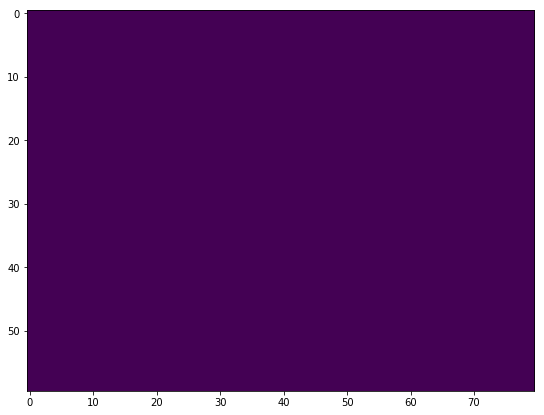

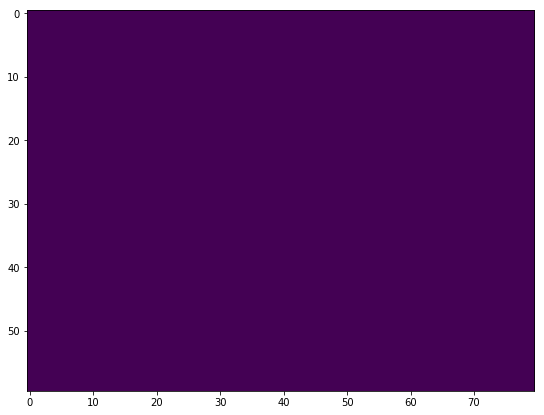

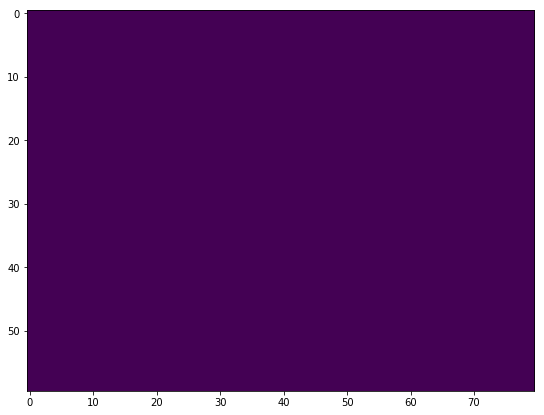

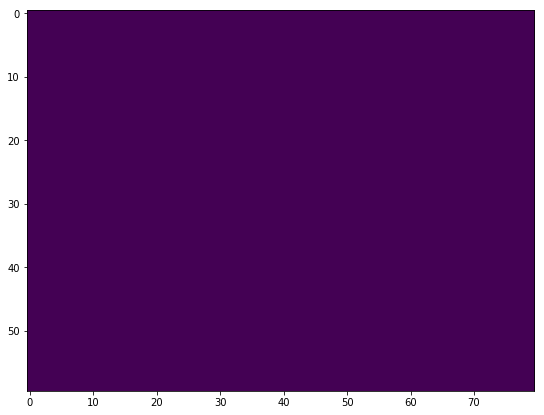

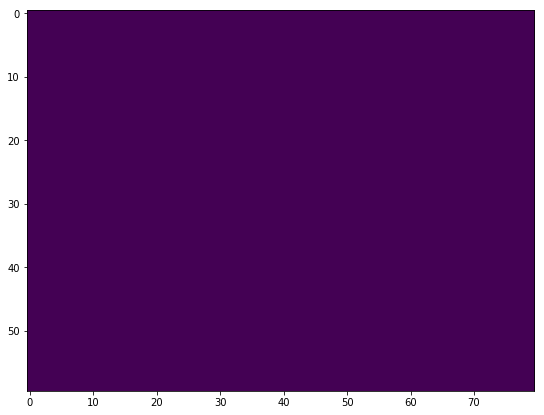

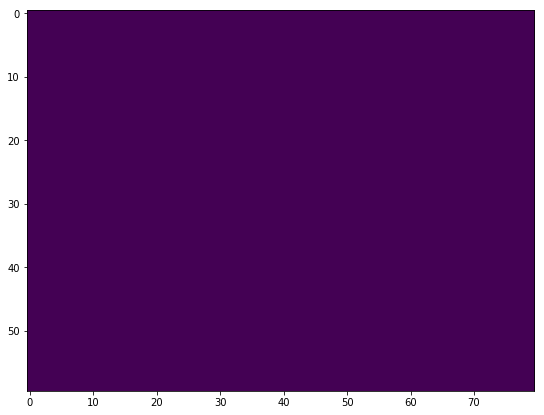

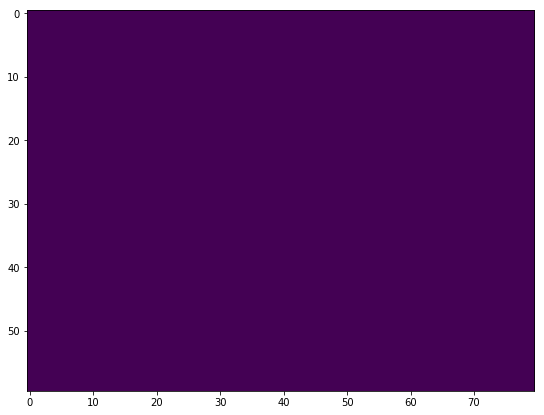

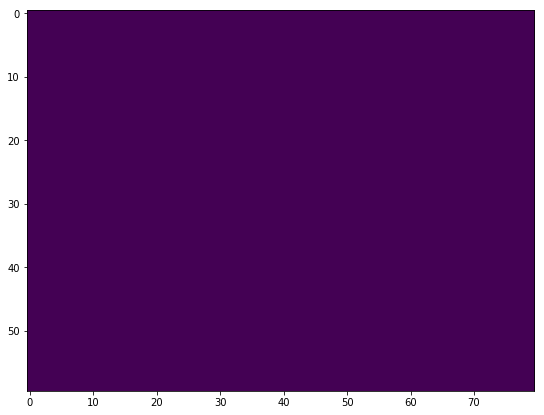

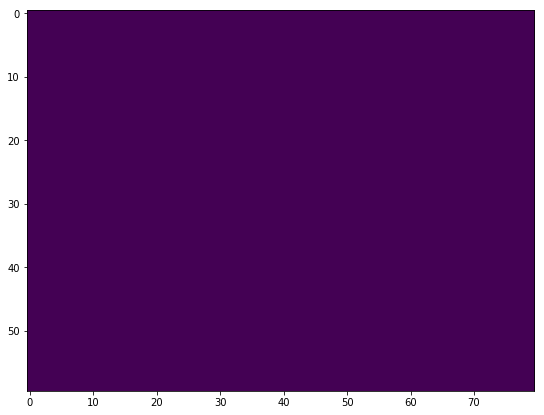

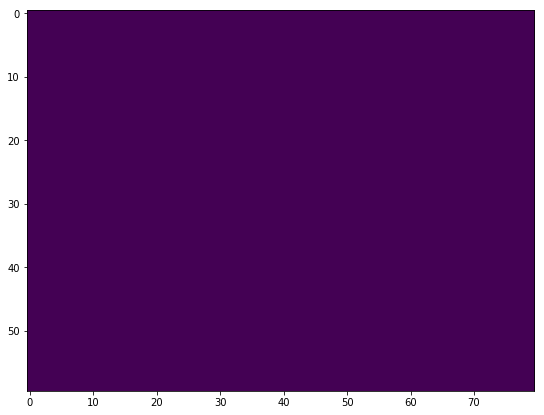

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


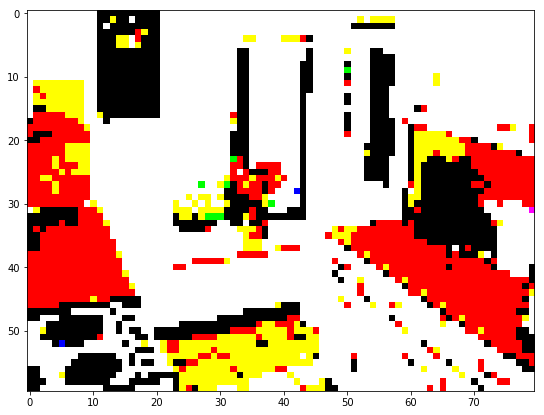

In [35]:

def convert2rgb(prediction):
    height, width, depth = prediction.shape
    res = np.zeros((height, width))
    for x in range(0, width):
        for y in range(0, height):
            dimension = np.argmax(prediction[y, x, :])
            if type(dimension) is not int:
                dimension = int(dimension * 255)
            res[y,x] = dimension
    return res




for i in range(0,10):
    img = testImg.next()
    prediction = model.predict(img)
    grayscale = convert2rgb(prediction[0,:,:,:])
    plt.figure(i, figsize=(20,7))
    plt.imshow(np.array(grayscale*255, dtype=np.int8))
    
    if i == 0:
        print(prediction[0,:,:,:])
    
plt.show()

plt.figure(11, figsize=(20,7))
plt.imshow(np.array(testImg.next()[0]*255, dtype=np.int8))
plt.show()


In [44]:





# print(predictions[0,:,:,:])

# print(img[0,:,:,:].shape)
# print(img[0,:,:,:])

# print(np.max(label[0,:,:,0]))
# 
# plt.figure(2, figsize=(20,7))
# plt.imshow( img[0,:,:,0].astype(int))
# plt.show()
# 
# plt.figure(3, figsize=(20,7))
# plt.imshow(label[0,:,:,:].astype(int))
# plt.show()

# print(label[0,:,:,:])

# Exc. 7.2 FCN mit Bottleneck

Implementiere jetzt die Variante mit schrittweisem Down- und Upsampling, wie in der Vorlesung besprochen. Nutze dafür ein bestehendes Netzwerk (z.B. VGG16, https://keras.io/applications/#vgg16), entferne die FC-Schichten am Ende, und füge dann die Upsampling-Schichten hinzu. Wie in der vorigen Vorlesung zu Transfer Learning beschrieben, kannst Du jetzt nur den zweiten Teil trainieren und die Gewichte des ersten Teils "einfrieren".

Stelle wie oben den Verlauf des Losses dar und wähle einige Beispielbilder aus dem Testset und zeige sie mit ihrer vorhergesagten Segmentierung an. (**BONUS**)